## Define df

In [1]:
# Run this ONCE near the top of the notebook, show full plot/ table

# Sharper inline images
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Bigger, clearer figures by default
mpl.rcParams.update({
    "figure.figsize": (14, 7),          # default size for all plots
    "figure.dpi": 160,                   # sharper
    "figure.constrained_layout.use": True,
    "savefig.bbox": "tight",
    "figure.max_open_warning": 0,
})

# Remove output scrolling (works for JupyterLab + classic)
display(HTML("""
<style>
/* JupyterLab */
.jp-OutputArea, .jp-OutputArea-child, .jp-Cell-outputArea {
  max-height: none !important;
}
/* Classic Notebook */
.output_scroll, .output_wrapper, .output {
  height: auto !important; max-height: none !important;
  box-shadow: none !important; -webkit-box-shadow: none !important;
}
</style>
"""))

In [ ]:
# Step 0: Setup (CDR & BigQuery client)

In [2]:
import os
from google.cloud import bigquery

# All of Us CDR dataset (Workbench sets this)
CDR = os.environ["WORKSPACE_CDR"]  # e.g., 'fc-aou-cdr-prod.R2024Q2R6_deid'
bq = bigquery.Client()

In [ ]:
# Step 1: person join & outpatient concept set

In [3]:
def table_exists(dataset, table):
    q = f"""
      SELECT 1
      FROM `{dataset}.INFORMATION_SCHEMA.TABLES`
      WHERE LOWER(table_name) = @t
      LIMIT 1
    """
    res = bq.query(
        q,
        job_config=bigquery.QueryJobConfig(
            query_parameters=[bigquery.ScalarQueryParameter("t","STRING",table.lower())]
        ),
    ).result().to_dataframe()
    return not res.empty

if table_exists(CDR, "cb_search_person"):
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        cb.sex_at_birth,
        cb.race,
        cb.ethnicity,
        cb.state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.cb_search_person` cb
        ON cb.person_id = p.person_id
    )
    """
elif table_exists(CDR, "aou_person"):
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        ap.sex_at_birth,
        ap.race,
        ap.ethnicity,
        ap.state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.aou_person` ap
        ON ap.person_id = p.person_id
    )
    """
else:
    # Fallback to concept/location mapping (what we had before)
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        sex.concept_name  AS sex_at_birth,
        race.concept_name AS race,
        eth.concept_name  AS ethnicity,
        loc.state         AS state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.concept`  sex  ON sex.concept_id  = p.gender_concept_id
      LEFT JOIN `{CDR}.concept`  race ON race.concept_id = p.race_concept_id
      LEFT JOIN `{CDR}.concept`  eth  ON eth.concept_id  = p.ethnicity_concept_id
      LEFT JOIN `{CDR}.location` loc  ON loc.location_id = p.location_id
    )
    """

In [ ]:
# Step 2: Opioids (N02A) exposures, exclude Methadone (NO2AC52) & Buprenorphine (NO2AE01) 
# → opioids_NO2A_df

In [4]:
opioids_sql = f"""
WITH
-- ATC root for opioids (N02A)
atc_root AS (
  SELECT concept_id AS atc_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ATC' AND concept_code = 'N02A'
),

-- ATC nodes to exclude
excluded_atc AS (
  SELECT concept_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ATC'
    AND concept_code IN ('N02AC52','N02AE01')
),

-- All descendants under N02A
all_desc AS (
  SELECT DISTINCT ca.descendant_concept_id
  FROM `{CDR}.concept_ancestor` ca
  JOIN atc_root r
    ON ca.ancestor_concept_id = r.atc_id
),

-- Descendants of the excluded ATC nodes
excluded_desc AS (
  SELECT DISTINCT ca.descendant_concept_id
  FROM `{CDR}.concept_ancestor` ca
  JOIN excluded_atc e
    ON ca.ancestor_concept_id = e.concept_id
),

-- Keep N02A descendants that are NOT under the excluded branches; limit to standard Drug concepts
rxnorm_desc AS (
  SELECT d.descendant_concept_id AS drug_concept_id
  FROM all_desc d
  LEFT JOIN excluded_desc x
    ON d.descendant_concept_id = x.descendant_concept_id
  JOIN `{CDR}.concept` c
    ON c.concept_id = d.descendant_concept_id
  WHERE x.descendant_concept_id IS NULL
    AND c.domain_id = 'Drug'
    AND c.standard_concept = 'S'
)

SELECT
  de.*,
  dc.concept_name AS drug_concept_name
FROM `{CDR}.drug_exposure` de
JOIN rxnorm_desc r
  ON de.drug_concept_id = r.drug_concept_id
LEFT JOIN `{CDR}.concept` dc
  ON dc.concept_id = de.drug_concept_id
"""
opioids_NO2A_df = bq.query(opioids_sql).result().to_dataframe()

opioids_NO2A_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,route_concept_id,lot_number,provider_id,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,drug_concept_name
0,18000000003103472,1940537,35605848,2022-07-05,2022-07-05 14:44:00+00:00,2022-07-05,2022-07-05 00:00:00+00:00,None,581452,None,...,4142048.0,None,NaN,1.800000e+16,1.800000e+16,1732014,35605848.0,34206005,None,1 ML morphine sulfate 4 MG/ML Cartridge
1,47000000330998137,1420907,35605848,2018-04-12,2018-04-12 06:00:00+00:00,2018-05-12,2018-05-12 06:00:00+00:00,None,32868,None,...,4142048.0,None,NaN,4.700000e+16,4.700000e+16,1732014,35605848.0,34206005,None,1 ML morphine sulfate 4 MG/ML Cartridge
2,18000000002895818,1297039,35605848,2022-04-27,2022-04-27 16:34:00+00:00,2022-04-27,2022-04-27 00:00:00+00:00,None,581452,None,...,4142048.0,None,NaN,1.800000e+16,1.800000e+16,1732014,35605848.0,34206005,None,1 ML morphine sulfate 4 MG/ML Cartridge
3,18000000002830217,1209333,35605848,2023-06-30,2023-06-30 14:06:00+00:00,2023-07-01,2023-07-01 00:00:00+00:00,None,581452,None,...,4142048.0,None,NaN,1.800000e+16,1.800000e+16,1732014,35605848.0,34206005,None,1 ML morphine sulfate 4 MG/ML Cartridge
4,47000000003616230,1428951,35605848,2017-03-24,2017-03-24 06:00:00+00:00,2017-04-23,2017-04-23 06:00:00+00:00,None,32868,None,...,4142048.0,None,NaN,4.700000e+16,4.700000e+16,1732014,35605848.0,34206005,None,1 ML morphine sulfate 4 MG/ML Cartridge


In [5]:
opioids_NO2A_df.shape

(5291852, 24)

In [ ]:
# Step 3: Opioids + person join → opioids_NO2A_person_df

In [6]:
opioids_person_sql = f"""
WITH
{PERSON_JOIN},
atc_opioids AS (SELECT 21604254 AS atc_id),
rxnorm_desc AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_opioids a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id = 'Drug' AND c.standard_concept = 'S'
)
SELECT
  de.*,
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,
  dc.concept_name AS drug_concept_name
FROM `{CDR}.drug_exposure` de
JOIN rxnorm_desc r               ON de.drug_concept_id = r.drug_concept_id
JOIN person_demographics d       ON de.person_id = d.person_id
LEFT JOIN `{CDR}.concept` dc     ON dc.concept_id = de.drug_concept_id
"""
opioids_NO2A_person_df = bq.query(opioids_person_sql).result().to_dataframe()
opioids_NO2A_person_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,state_of_residence,gender_concept_id,year_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name
0,10000000002295729,2288142,40231925,2010-11-15,2010-11-15 03:06:55+00:00,2011-01-31,2011-01-31 00:00:00+00:00,None,44787730,None,...,CA,45878463,1982,1982-06-15 00:00:00+00:00,2100000001,38003563,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...
1,47000000131002109,1217987,40231925,2003-08-30,2003-08-30 06:00:00+00:00,2003-09-29,2003-09-29 06:00:00+00:00,None,32868,None,...,WI,45880669,1945,1945-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...
2,47000000087164079,1232645,40231925,2005-09-30,2005-09-30 06:00:00+00:00,2005-10-30,2005-10-30 06:00:00+00:00,None,32868,None,...,WI,45878463,1981,1981-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...
3,47000000137434432,7642676,40231925,2000-11-08,2000-11-08 06:00:00+00:00,2000-12-08,2000-12-08 06:00:00+00:00,None,32868,None,...,WI,45878463,1962,1962-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...
4,9000000000229370,1603297,40231925,2019-09-24,2019-09-24 00:00:00+00:00,2020-05-22,2020-05-22 20:22:00+00:00,None,44787730,None,...,CA,45878463,1940,1940-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...


In [7]:
opioids_NO2A_person_df.shape

(5372205, 36)

In [8]:
# Check the readable columns (translate from OMOP concept code)
print([c for c in opioids_NO2A_person_df.columns if c in ["sex_at_birth","race","ethnicity","state_of_residence"]])

# Show both: names + codes side-by-side
opioids_NO2A_person_df[
    ["sex_at_birth","gender_concept_id","race","race_concept_id","ethnicity","ethnicity_concept_id","state_of_residence","location_id","drug_concept_name"]
].head(10)

['sex_at_birth', 'race', 'ethnicity', 'state_of_residence']


,sex_at_birth,gender_concept_id,race,race_concept_id,ethnicity,ethnicity_concept_id,state_of_residence,location_id,drug_concept_name
0,Female,45878463,None Indicated,2100000001,Hispanic or Latino,38003563,CA,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
1,Male,45880669,White,8527,Not Hispanic or Latino,38003564,WI,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
2,Female,45878463,White,8527,Not Hispanic or Latino,38003564,WI,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
3,Female,45878463,White,8527,Not Hispanic or Latino,38003564,WI,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
4,Female,45878463,Black or African American,8516,Not Hispanic or Latino,38003564,CA,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
5,Female,45878463,White,8527,Not Hispanic or Latino,38003564,WI,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
6,Male,45880669,White,8527,Not Hispanic or Latino,38003564,WI,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
7,Male,45880669,White,8527,Not Hispanic or Latino,38003564,CA,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
8,Male,45880669,White,8527,Not Hispanic or Latino,38003564,IN,NaN,acetaminophen 325 MG / oxycodone hydrochloride...
9,Male,45880669,Skip,903096,Skip,903096,AZ,NaN,acetaminophen 325 MG / oxycodone hydrochloride...


In [ ]:
# Step 4: A10 ∪ C10 exposures → diabetes_A10_lipid_C10_df

In [9]:
a10_c10_sql = f"""
WITH
atc_ctrl AS (
  SELECT 21600712 AS atc_id  -- A10: Drugs used in diabetes
  UNION ALL
  SELECT 21601853            -- C10: Lipid modifying agents
),
rxnorm_desc AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_ctrl a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id = 'Drug' AND c.standard_concept = 'S'
)
SELECT
  de.*,
  dc.concept_name AS drug_concept_name
FROM `{CDR}.drug_exposure` de
JOIN rxnorm_desc r           ON de.drug_concept_id = r.drug_concept_id
LEFT JOIN `{CDR}.concept` dc ON dc.concept_id = de.drug_concept_id
"""
diabetes_A10_lipid_C10_df = bq.query(a10_c10_sql).result().to_dataframe()
diabetes_A10_lipid_C10_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,route_concept_id,lot_number,provider_id,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,drug_concept_name
0,26000000020934738,6789073,741834,2023-08-09,2023-08-09 00:00:00+00:00,2023-08-09,2023-08-09 00:00:00+00:00,2023-08-09,32865,None,...,4142048.0,None,NaN,2.600000e+16,NaN,2619154,741834.0,34206005,None,"0.25 MG, 0.5 MG Dose 3 ML semaglutide 0.68 MG/..."
1,26000000020945026,2802834,741834,2023-06-27,2023-06-27 00:00:00+00:00,2023-07-28,2023-07-28 00:00:00+00:00,2023-07-28,32865,None,...,4142048.0,None,NaN,2.600000e+16,NaN,2619154,741834.0,34206005,None,"0.25 MG, 0.5 MG Dose 3 ML semaglutide 0.68 MG/..."
2,39000000000148957,1742175,741834,2023-08-24,2023-08-24 00:00:00+00:00,2023-08-24,2023-08-24 18:19:00+00:00,2023-08-24,4354238,None,...,4142048.0,None,NaN,3.900000e+16,NaN,2619154,741834.0,34206005,None,"0.25 MG, 0.5 MG Dose 3 ML semaglutide 0.68 MG/..."
3,18000000001823116,1387890,19077659,2008-04-20,2008-04-20 02:07:00+00:00,2008-05-20,2008-05-20 14:51:00+00:00,None,44787730,None,...,4132161.0,None,NaN,1.800000e+16,1.800000e+16,310534,19077659.0,26643006,None,glyburide 2.5 MG Oral Tablet
4,10000000003064473,1005424,19077659,2011-06-28,2011-06-28 11:08:45+00:00,2011-07-08,2011-07-08 15:27:57+00:00,None,44787730,None,...,4132161.0,None,NaN,1.000000e+16,NaN,310534,19077659.0,26643006,None,glyburide 2.5 MG Oral Tablet


In [10]:
diabetes_A10_lipid_C10_df.shape

(7099710, 24)

In [ ]:
# Step 5: A10 ∪ C10 + person join → diabetes_A10_lipid_C10_person_df

In [11]:
a10_c10_person_sql = f"""
WITH
{PERSON_JOIN},
atc_ctrl AS (
  SELECT 21600712 AS atc_id
  UNION ALL SELECT 21601853
),
rxnorm_desc AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_ctrl a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id = 'Drug' AND c.standard_concept = 'S'
)
SELECT
  de.*,
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,
  dc.concept_name AS drug_concept_name
FROM `{CDR}.drug_exposure` de
JOIN rxnorm_desc r           ON de.drug_concept_id = r.drug_concept_id
JOIN person_demographics d   ON de.person_id = d.person_id
LEFT JOIN `{CDR}.concept` dc ON dc.concept_id = de.drug_concept_id
"""
diabetes_A10_lipid_C10_person_df = bq.query(a10_c10_person_sql).result().to_dataframe()
diabetes_A10_lipid_C10_person_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,state_of_residence,gender_concept_id,year_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name
0,9000000000077141,1513434,40164897,2018-02-20,2018-02-20 00:00:00+00:00,2018-03-12,2018-03-12 15:11:00+00:00,None,44787730,None,...,CA,45878463,1942,1942-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,metformin hydrochloride 1000 MG Oral Tablet
1,39000000000147906,1084178,40164897,2008-08-18,2008-08-18 00:00:00+00:00,2009-01-15,2009-01-15 00:33:00+00:00,2009-01-15,4354238,None,...,WI,45878463,1970,1970-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,metformin hydrochloride 1000 MG Oral Tablet
2,10000000002645461,1740378,40164897,2016-12-15,2016-12-15 14:58:36+00:00,2017-08-11,2017-08-11 14:20:24+00:00,None,44787730,None,...,CA,45880669,1953,1953-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,metformin hydrochloride 1000 MG Oral Tablet
3,52000000000150624,3259165,40164897,2016-04-04,2016-04-04 00:00:00+00:00,2018-07-02,2018-07-02 00:00:00+00:00,None,44787730,None,...,MS,903096,1962,1962-06-15 00:00:00+00:00,8657,38003564,NaN,NaN,None,metformin hydrochloride 1000 MG Oral Tablet
4,39000000000201275,6614513,40164897,2019-04-24,2019-04-24 00:00:00+00:00,2019-06-15,2019-06-15 22:00:00+00:00,2019-06-15,4354238,None,...,MN,45878463,1974,1974-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,metformin hydrochloride 1000 MG Oral Tablet


In [12]:
diabetes_A10_lipid_C10_person_df.shape

(7099710, 36)

In [ ]:
# Step 6: A10 ∪ C10 (exclude opioid persons) → A10_C10_person_exclude_NO2A_df

In [13]:
control_base_sql = f"""
WITH
{PERSON_JOIN},

-- opioid set (to exclude persons)
atc_opioids AS (SELECT 21604254 AS atc_id),
opioid_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_opioids a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id='Drug' AND c.standard_concept='S'
),
opioid_users AS (
  SELECT DISTINCT de.person_id
  FROM `{CDR}.drug_exposure` de
  JOIN opioid_rxnorm r ON de.drug_concept_id = r.drug_concept_id
),

-- control set (A10 ∪ C10)
atc_ctrl AS (
  SELECT 21600712 AS atc_id   -- A10
  UNION ALL SELECT 21601853    -- C10
),
ctrl_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_ctrl a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id='Drug' AND c.standard_concept='S'
)

SELECT
  de.*,
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,
  dc.concept_name AS drug_concept_name
FROM `{CDR}.drug_exposure` de
JOIN ctrl_rxnorm r           ON de.drug_concept_id = r.drug_concept_id
JOIN person_demographics d   ON de.person_id       = d.person_id
LEFT JOIN `{CDR}.concept` dc ON dc.concept_id      = de.drug_concept_id
LEFT JOIN opioid_users ou    ON ou.person_id       = d.person_id
WHERE ou.person_id IS NULL
"""
A10_C10_person_exclude_NO2A_df = bq.query(control_base_sql).result().to_dataframe()
A10_C10_person_exclude_NO2A_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,state_of_residence,gender_concept_id,year_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name
0,3000000000539901,5489211,42708171,2018-07-10,2018-07-10 00:00:00+00:00,2018-08-08,2018-08-08 00:00:00+00:00,None,32838,None,...,NC,45878463,1959,1959-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,24 HR metformin hydrochloride 1000 MG / sitagl...
1,3000000000539764,5489211,42708171,2018-10-15,2018-10-15 00:00:00+00:00,2018-11-13,2018-11-13 00:00:00+00:00,None,32838,None,...,NC,45878463,1959,1959-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,24 HR metformin hydrochloride 1000 MG / sitagl...
2,30000000000018151,2891243,42708171,2019-02-06,2019-02-06 00:00:00+00:00,2021-10-25,2021-10-25 00:00:00+00:00,None,38000177,None,...,CT,45878463,1989,1989-06-15 00:00:00+00:00,2100000001,38003563,NaN,NaN,None,24 HR metformin hydrochloride 1000 MG / sitagl...
3,3000000000539788,5489211,42708171,2022-07-25,2022-07-25 00:00:00+00:00,2022-08-23,2022-08-23 00:00:00+00:00,None,32838,None,...,NC,45878463,1959,1959-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,24 HR metformin hydrochloride 1000 MG / sitagl...
4,3000000000494930,8194975,42708171,2019-08-06,2019-08-06 00:00:00+00:00,2020-06-22,2020-06-22 23:59:59.900000+00:00,None,32838,None,...,KY,45880669,1958,1958-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,24 HR metformin hydrochloride 1000 MG / sitagl...


In [14]:
A10_C10_person_exclude_NO2A_df.shape

(880270, 36)

In [ ]:
# Step 7: Outpatient-only opioids (case cohort) → case_df

In [15]:
# Define OUTPATIENT_SET (Outpatient visit, 9202)

import os
from google.cloud import bigquery

# Workspace CDR + BigQuery client
CDR = os.environ["WORKSPACE_CDR"]   # e.g., 'fc-aou-cdr-prod.R2024Q2R6_deid'
bq = bigquery.Client()

# Helper: check table existence
def _table_exists(dataset: str, table: str) -> bool:
    q = """
      SELECT 1
      FROM `{}.INFORMATION_SCHEMA.TABLES`
      WHERE LOWER(table_name) = @t
      LIMIT 1
    """.format(dataset)
    df = bq.query(
        q,
        job_config=bigquery.QueryJobConfig(
            query_parameters=[bigquery.ScalarQueryParameter("t","STRING",table.lower())]
        ),
    ).result().to_dataframe()
    return not df.empty

# Prefer AoU curated demographics if available; else fall back to OMOP concept/location lookup
if _table_exists(CDR, "cb_search_person"):
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        cb.sex_at_birth,
        cb.race,
        cb.ethnicity,
        cb.state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.cb_search_person` cb
        ON cb.person_id = p.person_id
    )
    """
elif _table_exists(CDR, "aou_person"):
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        ap.sex_at_birth,
        ap.race,
        ap.ethnicity,
        ap.state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.aou_person` ap
        ON ap.person_id = p.person_id
    )
    """
else:
    PERSON_JOIN = f"""
    person_demographics AS (
      SELECT
        p.person_id,
        p.gender_concept_id, p.year_of_birth, p.birth_datetime,
        p.race_concept_id, p.ethnicity_concept_id,
        p.location_id, p.care_site_id, p.person_source_value,
        sex.concept_name  AS sex_at_birth,
        race.concept_name AS race,
        eth.concept_name  AS ethnicity,
        loc.state         AS state_of_residence
      FROM `{CDR}.person` p
      LEFT JOIN `{CDR}.concept`  sex  ON sex.concept_id  = p.gender_concept_id
      LEFT JOIN `{CDR}.concept`  race ON race.concept_id = p.race_concept_id
      LEFT JOIN `{CDR}.concept`  eth  ON eth.concept_id  = p.ethnicity_concept_id
      LEFT JOIN `{CDR}.location` loc  ON loc.location_id = p.location_id
    )
    """

# Outpatient visit subtree (9202) used by case_df
OUTPATIENT_SET = f"""
outpatient_desc AS (
  SELECT descendant_concept_id AS visit_concept_id
  FROM `{CDR}.concept_ancestor`
  WHERE ancestor_concept_id = 9202
)
"""

In [16]:
case_sql = f"""
WITH
{PERSON_JOIN},
{OUTPATIENT_SET},
atc_opioids AS (SELECT 21604254 AS atc_id),
rxnorm_desc AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_opioids a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id='Drug' AND c.standard_concept='S'
)
SELECT
  de.*,
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,
  dc.concept_name AS drug_concept_name,
  v.visit_concept_id,
  vc.concept_name AS visit_concept_name,
  TRUE AS is_outpatient
FROM `{CDR}.drug_exposure` de
JOIN rxnorm_desc r                 ON de.drug_concept_id   = r.drug_concept_id
JOIN person_demographics d         ON de.person_id         = d.person_id
JOIN `{CDR}.visit_occurrence` v    ON de.visit_occurrence_id = v.visit_occurrence_id
JOIN outpatient_desc od            ON v.visit_concept_id   = od.visit_concept_id
LEFT JOIN `{CDR}.concept` vc       ON vc.concept_id        = v.visit_concept_id
LEFT JOIN `{CDR}.concept` dc       ON dc.concept_id        = de.drug_concept_id
"""
case_df = bq.query(case_sql).result().to_dataframe()
case_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name,visit_concept_id,visit_concept_name,is_outpatient
0,5000000010442338,3039855,40223271,2017-01-05,2017-01-05 05:00:00+00:00,None,NaT,None,38000177,None,...,1951-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,aspirin 325 MG / butalbital 50 MG / caffeine 4...,581477,Office Visit,True
1,5000000010855980,3039855,40223271,2017-01-05,2017-01-05 05:00:00+00:00,2017-01-05,2017-01-05 05:00:00+00:00,None,38000177,None,...,1951-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,aspirin 325 MG / butalbital 50 MG / caffeine 4...,581477,Office Visit,True
2,5000000004288061,3168980,40223271,2006-05-19,2006-05-19 05:00:00+00:00,2007-12-14,2007-12-14 05:00:00+00:00,None,38000177,None,...,1954-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,aspirin 325 MG / butalbital 50 MG / caffeine 4...,581477,Office Visit,True
3,5000000009809043,3300619,40223271,2013-10-28,2013-10-28 05:00:00+00:00,2014-04-25,2014-04-25 05:00:00+00:00,None,38000177,None,...,1949-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,aspirin 325 MG / butalbital 50 MG / caffeine 4...,581477,Office Visit,True
4,22000014531546107,1597998,40231922,2023-06-26,2023-06-26 18:43:00+00:00,2023-07-25,2023-07-25 06:00:00+00:00,None,38000178,None,...,1957-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,acetaminophen 325 MG / oxycodone hydrochloride...,581477,Office Visit,True


In [17]:
case_df.shape

(1351059, 39)

In [ ]:
# Step 8: Apply outpatient filter to get control_df (mirrors case_df’s visit fields)

In [18]:
control_outpatient_sql = f"""
WITH
{PERSON_JOIN},
{OUTPATIENT_SET},

-- opioid set (to exclude persons)
atc_opioids AS (SELECT 21604254 AS atc_id),
opioid_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_opioids a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id='Drug' AND c.standard_concept='S'
),
opioid_users AS (
  SELECT DISTINCT de.person_id
  FROM `{CDR}.drug_exposure` de
  JOIN opioid_rxnorm r ON de.drug_concept_id = r.drug_concept_id
),

-- control set (A10 ∪ C10)
atc_ctrl AS (
  SELECT 21600712 AS atc_id   -- A10
  UNION ALL SELECT 21601853    -- C10
),
ctrl_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM atc_ctrl a
  JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
  JOIN `{CDR}.concept` c ON c.concept_id = ca.descendant_concept_id
  WHERE c.domain_id='Drug' AND c.standard_concept='S'
)

SELECT
  de.*,
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,
  dc.concept_name AS drug_concept_name,
  v.visit_concept_id,
  vc.concept_name AS visit_concept_name,
  TRUE AS is_outpatient
FROM `{CDR}.drug_exposure` de
JOIN ctrl_rxnorm r                 ON de.drug_concept_id    = r.drug_concept_id
JOIN person_demographics d         ON de.person_id          = d.person_id
LEFT JOIN `{CDR}.concept` dc       ON dc.concept_id         = de.drug_concept_id
JOIN `{CDR}.visit_occurrence` v    ON de.visit_occurrence_id = v.visit_occurrence_id
JOIN outpatient_desc od            ON v.visit_concept_id    = od.visit_concept_id
LEFT JOIN `{CDR}.concept` vc       ON vc.concept_id         = v.visit_concept_id
LEFT JOIN opioid_users ou          ON ou.person_id          = d.person_id
WHERE ou.person_id IS NULL
"""
control_df = bq.query(control_outpatient_sql).result().to_dataframe()
control_df.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,verbatim_end_date,drug_type_concept_id,stop_reason,...,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name,visit_concept_id,visit_concept_name,is_outpatient
0,21000000000029329,1751992,1545958,2016-10-18,2016-10-18 00:00:00+00:00,2017-03-22,2017-03-22 00:00:00+00:00,None,38000177,None,...,1963-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,atorvastatin,38004246,Ambulatory Physical Therapy Clinic / Center,True
1,21000000000024129,1532797,19004081,2016-03-08,2016-03-08 00:00:00+00:00,2016-06-06,2016-06-06 00:00:00+00:00,None,38000177,None,...,1954-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,simvastatin 10 MG Oral Tablet [Zocor],38004246,Ambulatory Physical Therapy Clinic / Center,True
2,21000000000004107,1477744,19098474,2013-11-14,2013-11-14 00:00:00+00:00,2014-01-16,2014-01-16 00:00:00+00:00,None,38000177,None,...,1961-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,ezetimibe 10 MG Oral Tablet [Zetia],38004246,Ambulatory Physical Therapy Clinic / Center,True
3,21000000000004498,1238758,1545999,2013-11-19,2013-11-19 00:00:00+00:00,2014-04-15,2014-04-15 00:00:00+00:00,None,38000177,None,...,1963-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,atorvastatin 20 MG Oral Tablet [Lipitor],38004246,Ambulatory Physical Therapy Clinic / Center,True
4,21000000000018402,1252911,40165257,2015-08-11,2015-08-11 00:00:00+00:00,2015-08-11,2015-08-11 00:00:00+00:00,None,38000177,None,...,1963-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,rosuvastatin calcium 40 MG Oral Tablet,38004246,Ambulatory Physical Therapy Clinic / Center,True


In [19]:
control_df.shape

(258204, 39)

In [20]:
case_df.shape

(1351059, 39)

In [21]:
# List all column names for case_df and control_df

def list_cols(df, name):
    print(f"\n{name} — {len(df.columns)} columns")
    print("-" * (len(name) + 15))
    for i, c in enumerate(df.columns, 1):
        print(f"{i:>3}. {c}")

list_cols(case_df, "case_df")
list_cols(control_df, "control_df")


case_df — 39 columns
----------------------
  1. drug_exposure_id
  2. person_id
  3. drug_concept_id
  4. drug_exposure_start_date
  5. drug_exposure_start_datetime
  6. drug_exposure_end_date
  7. drug_exposure_end_datetime
  8. verbatim_end_date
  9. drug_type_concept_id
 10. stop_reason
 11. refills
 12. quantity
 13. days_supply
 14. sig
 15. route_concept_id
 16. lot_number
 17. provider_id
 18. visit_occurrence_id
 19. visit_detail_id
 20. drug_source_value
 21. drug_source_concept_id
 22. route_source_value
 23. dose_unit_source_value
 24. sex_at_birth
 25. race
 26. ethnicity
 27. state_of_residence
 28. gender_concept_id
 29. year_of_birth
 30. birth_datetime
 31. race_concept_id
 32. ethnicity_concept_id
 33. location_id
 34. care_site_id
 35. person_source_value
 36. drug_concept_name
 37. visit_concept_id
 38. visit_concept_name
 39. is_outpatient

control_df — 39 columns
-------------------------
  1. drug_exposure_id
  2. person_id
  3. drug_concept_id
  4. drug_exposur

In [29]:
# Build AoU_drug_df: ALL outpatient drug_exposure rows + selected person columns
# Requires: CDR, bq, PERSON_JOIN already defined

# ---- Compose SQL (outpatient-only to keep it feasible) ----
AoU_outpatient_sql = f"""
WITH
{PERSON_JOIN},
-- Outpatient visit subtree (9202)
outpatient_desc AS (
  SELECT descendant_concept_id AS visit_concept_id
  FROM `{CDR}.concept_ancestor`
  WHERE ancestor_concept_id = 9202
)

SELECT
  -- drug_exposure (selected high-value columns; add more if you need them)
  de.drug_exposure_id,
  de.person_id,
  de.drug_concept_id,
  de.drug_exposure_start_date,
  de.drug_exposure_start_datetime,
  de.drug_exposure_end_date,
  de.drug_exposure_end_datetime,
  de.days_supply,
  de.quantity,
  de.refills,
  de.sig,
  de.route_concept_id,
  de.provider_id,
  de.visit_occurrence_id,
  de.drug_source_value,
  de.drug_source_concept_id,
  de.route_source_value,
  de.dose_unit_source_value,

  -- person (readable + OMOP-coded, like your cohorts)
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,

  -- drug concept name
  dc.concept_name AS drug_concept_name,

  -- visit (outpatient only)
  v.visit_concept_id,
  vc.concept_name AS visit_concept_name,
  TRUE AS is_outpatient

FROM `{CDR}.drug_exposure` de
JOIN person_demographics d      ON de.person_id          = d.person_id
JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
JOIN outpatient_desc od         ON v.visit_concept_id    = od.visit_concept_id
LEFT JOIN `{CDR}.concept` vc    ON vc.concept_id         = v.visit_concept_id
LEFT JOIN `{CDR}.concept` dc    ON dc.concept_id         = de.drug_concept_id
"""

# ---- 1) Get a row count first (same FROM/JOIN/WHERE) ----
count_sql = "SELECT COUNT(*) AS n FROM (" + AoU_outpatient_sql + ")"
n_rows = int(bq.query(count_sql).result().to_dataframe()["n"].iloc[0])
print(f"Outpatient drug_exposure rows to download: {n_rows:,}")

# ---- 2) Download with BigQuery Storage API (faster, lower memory overhead than REST) ----
AoU_drug_df = bq.query(AoU_outpatient_sql).result().to_dataframe(create_bqstorage_client=True)

# Peek
print(AoU_drug_df.shape)
AoU_drug_df.head(5)

Outpatient drug_exposure rows to download: 35,257,903
(35257903, 34)


,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,days_supply,quantity,refills,...,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name,visit_concept_id,visit_concept_name,is_outpatient
0,31000000004341680,1247763,43011891,2022-10-03,2022-10-03 14:00:00+00:00,2022-10-03,2022-10-03 15:23:00+00:00,NaN,NaN,NaN,...,1984-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,"1 ML heparin sodium, porcine 100 UNT/ML Prefil...",9202,Outpatient Visit,True
1,10000000002085320,2910394,42800173,2020-11-14,2020-11-14 00:00:00+00:00,2020-12-18,2020-12-18 17:08:00+00:00,NaN,NaN,NaN,...,1997-06-15 00:00:00+00:00,2100000001,38003563,NaN,NaN,None,hydrocortisone acetate 25 MG Rectal Suppository,9202,Outpatient Visit,True
2,18000000000927407,2056706,44816278,2008-07-01,2008-07-01 16:54:00+00:00,2008-10-24,2008-10-24 14:31:00+00:00,NaN,3.0,3.0,...,1969-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,168 HR ethinyl estradiol 0.00146 MG/HR / norel...,9202,Outpatient Visit,True
3,18000000002340262,3519308,40224806,2011-04-08,2011-04-08 14:34:00+00:00,2016-02-17,2016-02-17 16:04:00+00:00,NaN,NaN,NaN,...,1970-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,1 ML medroxyprogesterone acetate 150 MG/ML Inj...,9202,Outpatient Visit,True
4,47000000241279655,1115979,42800173,2005-09-29,2005-09-29 06:00:00+00:00,2005-10-29,2005-10-29 06:00:00+00:00,NaN,10.0,NaN,...,1967-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,hydrocortisone acetate 25 MG Rectal Suppository,9202,Outpatient Visit,True


## Ingredient

In [ ]:
# Step 7 (skip): Enrich case_df and control_df with drug & ingredient columns

In [ ]:
# # Build row-per-ingredient versions: case_ingredient_df / control_ingredient_df
# # ========= Per-ingredient cohorts =========

# # ----- CASE: N02A opioids, outpatient only, one row per ingredient -----
# case_ing_sql = f"""
# WITH
# {PERSON_JOIN},
# {OUTPATIENT_SET},

# -- ATC N02A: Opioids
# atc_opioids AS (SELECT 21604254 AS atc_id),
# opioid_rxnorm AS (
#   SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
#   FROM atc_opioids a
#   JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
#   JOIN `{CDR}.concept` c           ON c.concept_id = ca.descendant_concept_id
#   WHERE c.domain_id = 'Drug' AND c.standard_concept = 'S'
# ),

# -- Map each opioid drug_concept_id to its Ingredient ancestor(s)
# ingredients AS (
#   SELECT
#     ca.descendant_concept_id AS drug_concept_id,
#     ca.ancestor_concept_id   AS ingredient_concept_id
#   FROM `{CDR}.concept_ancestor` ca
#   JOIN `{CDR}.concept` ci ON ci.concept_id = ca.ancestor_concept_id
#   WHERE ci.domain_id='Drug' AND ci.standard_concept='S' AND ci.concept_class_id='Ingredient'
# ),

# -- If an exposure is itself at Ingredient class, include it
# direct_ingredient AS (
#   SELECT
#     r.drug_concept_id,
#     r.drug_concept_id AS ingredient_concept_id
#   FROM opioid_rxnorm r
#   JOIN `{CDR}.concept` d ON d.concept_id = r.drug_concept_id
#   WHERE d.domain_id='Drug' AND d.standard_concept='S' AND d.concept_class_id='Ingredient'
# ),

# drug_to_ingredient AS (
#   SELECT * FROM ingredients
#    WHERE drug_concept_id IN (SELECT drug_concept_id FROM opioid_rxnorm)
#   UNION ALL
#   SELECT * FROM direct_ingredient
# )

# SELECT
#   de.*,

#   -- person (readable + IDs)
#   d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
#   d.gender_concept_id, d.year_of_birth, d.birth_datetime,
#   d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,

#   -- drug concept name
#   dc.concept_name AS drug_concept_name,

#   -- per-ingredient columns
#   di.ingredient_concept_id,
#   ic.concept_name AS ingredient,

#   -- visit (outpatient only)
#   v.visit_concept_id,
#   vc.concept_name AS visit_concept_name,
#   TRUE AS is_outpatient

# FROM `{CDR}.drug_exposure` de
# JOIN opioid_rxnorm r                ON de.drug_concept_id    = r.drug_concept_id
# JOIN person_demographics d          ON de.person_id          = d.person_id
# JOIN `{CDR}.visit_occurrence` v     ON de.visit_occurrence_id = v.visit_occurrence_id
# JOIN outpatient_desc od             ON v.visit_concept_id    = od.visit_concept_id
# LEFT JOIN `{CDR}.concept` vc        ON vc.concept_id         = v.visit_concept_id
# LEFT JOIN `{CDR}.concept` dc        ON dc.concept_id         = de.drug_concept_id
# JOIN drug_to_ingredient di          ON di.drug_concept_id    = de.drug_concept_id
# LEFT JOIN `{CDR}.concept` ic        ON ic.concept_id         = di.ingredient_concept_id
# """

# case_ingredient_df = bq.query(case_ing_sql).result().to_dataframe()


# # ----- CONTROL: A10 ∪ C10 (exclude any opioid user), one row per ingredient -----
# control_ing_sql = f"""
# WITH
# {PERSON_JOIN},

# -- Opioids to EXCLUDE persons
# atc_opioids AS (SELECT 21604254 AS atc_id),
# opioid_rxnorm AS (
#   SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
#   FROM atc_opioids a
#   JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
#   JOIN `{CDR}.concept` c           ON c.concept_id = ca.descendant_concept_id
#   WHERE c.domain_id='Drug' AND c.standard_concept='S'
# ),
# opioid_users AS (
#   SELECT DISTINCT de.person_id
#   FROM `{CDR}.drug_exposure` de
#   JOIN opioid_rxnorm r ON de.drug_concept_id = r.drug_concept_id
# ),

# -- Controls: A10 ∪ C10
# atc_ctrl AS (
#   SELECT 21600712 AS atc_id          -- A10
#   UNION ALL SELECT 21601853          -- C10
# ),
# ctrl_rxnorm AS (
#   SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
#   FROM atc_ctrl a
#   JOIN `{CDR}.concept_ancestor` ca ON ca.ancestor_concept_id = a.atc_id
#   JOIN `{CDR}.concept` c           ON c.concept_id = ca.descendant_concept_id
#   WHERE c.domain_id='Drug' AND c.standard_concept='S'
# ),

# -- Ingredients for control drugs
# ingredients AS (
#   SELECT
#     ca.descendant_concept_id AS drug_concept_id,
#     ca.ancestor_concept_id   AS ingredient_concept_id
#   FROM `{CDR}.concept_ancestor` ca
#   JOIN `{CDR}.concept` ci ON ci.concept_id = ca.ancestor_concept_id
#   WHERE ci.domain_id='Drug' AND ci.standard_concept='S' AND ci.concept_class_id='Ingredient'
# ),
# direct_ingredient AS (
#   SELECT
#     r.drug_concept_id,
#     r.drug_concept_id AS ingredient_concept_id
#   FROM ctrl_rxnorm r
#   JOIN `{CDR}.concept` d ON d.concept_id = r.drug_concept_id
#   WHERE d.domain_id='Drug' AND d.standard_concept='S' AND d.concept_class_id='Ingredient'
# ),
# drug_to_ingredient AS (
#   SELECT * FROM ingredients
#    WHERE drug_concept_id IN (SELECT drug_concept_id FROM ctrl_rxnorm)
#   UNION ALL
#   SELECT * FROM direct_ingredient
# )

# SELECT
#   de.*,

#   -- person (readable + IDs)
#   d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
#   d.gender_concept_id, d.year_of_birth, d.birth_datetime,
#   d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,

#   -- drug concept name
#   dc.concept_name AS drug_concept_name,

#   -- per-ingredient columns
#   di.ingredient_concept_id,
#   ic.concept_name AS ingredient

# FROM `{CDR}.drug_exposure` de
# JOIN ctrl_rxnorm r                 ON de.drug_concept_id    = r.drug_concept_id
# JOIN person_demographics d         ON de.person_id          = d.person_id
# LEFT JOIN `{CDR}.concept` dc       ON dc.concept_id         = de.drug_concept_id
# JOIN drug_to_ingredient di         ON di.drug_concept_id    = de.drug_concept_id
# LEFT JOIN `{CDR}.concept` ic       ON ic.concept_id         = di.ingredient_concept_id
# LEFT JOIN opioid_users ou          ON ou.person_id          = d.person_id
# WHERE ou.person_id IS NULL
# """

# control_ingredient_df = bq.query(control_ing_sql).result().to_dataframe()

# # Quick peek
# display(case_ingredient_df.head(3))
# display(control_ingredient_df.head(3))
# case_ingredient_df.shape, control_ingredient_df.shape

In [ ]:
# case_ingredient_df.shape

In [ ]:
# control_ingredient_df.shape

## Person Level: Table One

In [ ]:
# Questions:

# 1. Should we also apply the "outpatient" filter to our control group? 
#(typical non-addicted drugs (ATC: C10, lipid modifying agents & ATC: A10, drugs used in diabetes))
# Yes, apply it to the control_df
# Done.

# 2. Should we use "race" and "ethnicity"?
# Include both
# Done.


# 3. Define "episode" . Define "Long-term-user".
#If the gap between the end of one event and the start of the next is < 30 days, treat them as the same episode.
#If the gap is ≥ 30 days, that starts a new episode.
#drug_episode_span_days = episode_end − episode_start

#Any episode with span ≥ 365 days (≈ 1 year) is a long‑term episode

#n_long_users = how many unique people meet that criterion for the drug/ ingredient.
#n_long_episodes = how many episodes (total) meet the criterion for the frug/ ingredient.


###
# Gap <= 30
# Episode duration >= 365
# gap = between events
# span = between episodes

# Comparison group


In [ ]:
# 1.Perform table one analysis between case and control using sumarized dataframe, each row = person
# Pick one-point for "Age" (Median age of each person, compute the median age of (lastest age - earliest age))
# Sex_at_birth (F/ M/ Other); Race; Age; State of residence; mean & medium & min & max & sd # of events; 
# The count of eposods longer than 1 year

# Person level Analysis (all go to table one)
    # AoU level table one (count: sex_at_birth, age, race, ethisity)
    # backgrounf information
# Event level Analysis

In [22]:
# Build AoU_drug_df: ALL outpatient drug_exposure rows + selected person columns
# Requires: CDR, bq, PERSON_JOIN already defined

# ---- Compose SQL (outpatient-only to keep it feasible) ----
AoU_outpatient_sql = f"""
WITH
{PERSON_JOIN},
-- Outpatient visit subtree (9202)
outpatient_desc AS (
  SELECT descendant_concept_id AS visit_concept_id
  FROM `{CDR}.concept_ancestor`
  WHERE ancestor_concept_id = 9202
)

SELECT
  -- drug_exposure (selected high-value columns; add more if you need them)
  de.drug_exposure_id,
  de.person_id,
  de.drug_concept_id,
  de.drug_exposure_start_date,
  de.drug_exposure_start_datetime,
  de.drug_exposure_end_date,
  de.drug_exposure_end_datetime,
  de.days_supply,
  de.quantity,
  de.refills,
  de.sig,
  de.route_concept_id,
  de.provider_id,
  de.visit_occurrence_id,
  de.drug_source_value,
  de.drug_source_concept_id,
  de.route_source_value,
  de.dose_unit_source_value,

  -- person (readable + OMOP-coded, like your cohorts)
  d.sex_at_birth, d.race, d.ethnicity, d.state_of_residence,
  d.gender_concept_id, d.year_of_birth, d.birth_datetime,
  d.race_concept_id, d.ethnicity_concept_id, d.location_id, d.care_site_id, d.person_source_value,

  -- drug concept name
  dc.concept_name AS drug_concept_name,

  -- visit (outpatient only)
  v.visit_concept_id,
  vc.concept_name AS visit_concept_name,
  TRUE AS is_outpatient

FROM `{CDR}.drug_exposure` de
JOIN person_demographics d      ON de.person_id          = d.person_id
JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
JOIN outpatient_desc od         ON v.visit_concept_id    = od.visit_concept_id
LEFT JOIN `{CDR}.concept` vc    ON vc.concept_id         = v.visit_concept_id
LEFT JOIN `{CDR}.concept` dc    ON dc.concept_id         = de.drug_concept_id
"""

# ---- 1) Get a row count first (same FROM/JOIN/WHERE) ----
count_sql = "SELECT COUNT(*) AS n FROM (" + AoU_outpatient_sql + ")"
n_rows = int(bq.query(count_sql).result().to_dataframe()["n"].iloc[0])
print(f"Outpatient drug_exposure rows to download: {n_rows:,}")

# ---- 2) Download with BigQuery Storage API (faster, lower memory overhead than REST) ----
AoU_drug_df = bq.query(AoU_outpatient_sql).result().to_dataframe(create_bqstorage_client=True)

# Peek
print(AoU_drug_df.shape)
AoU_drug_df.head(5)

Outpatient drug_exposure rows to download: 35,257,903
(35257903, 34)


,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_date,drug_exposure_start_datetime,drug_exposure_end_date,drug_exposure_end_datetime,days_supply,quantity,refills,...,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,care_site_id,person_source_value,drug_concept_name,visit_concept_id,visit_concept_name,is_outpatient
0,49000000024038632,2891330,19111620,2018-11-30,2018-11-30 09:00:00+00:00,2018-11-30,2018-11-30 09:00:00+00:00,NaN,NaN,NaN,...,1962-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,folic acid,9202,Outpatient Visit,True
1,31000000010242691,1247763,43011891,2022-12-12,2022-12-12 13:45:00+00:00,2022-12-12,2022-12-12 15:24:00+00:00,NaN,NaN,NaN,...,1984-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,"1 ML heparin sodium, porcine 100 UNT/ML Prefil...",9202,Outpatient Visit,True
2,24000000000792705,2720635,44093472,2020-02-06,2020-02-06 00:00:00+00:00,2020-02-06,2020-02-06 00:00:00+00:00,1.0,0.0,0.0,...,1973-06-15 00:00:00+00:00,8516,38003564,NaN,NaN,None,Diphenhydramine 50 MG [Nytol Quickgels],9202,Outpatient Visit,True
3,47000000243509469,1763216,42800173,2010-01-18,2010-01-18 06:00:00+00:00,2010-02-17,2010-02-17 06:00:00+00:00,NaN,20.0,NaN,...,1954-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,hydrocortisone acetate 25 MG Rectal Suppository,9202,Outpatient Visit,True
4,47000000403080675,1914216,42800173,2014-10-01,2014-10-01 06:00:00+00:00,2014-10-31,2014-10-31 06:00:00+00:00,NaN,30.0,NaN,...,1966-06-15 00:00:00+00:00,8527,38003564,NaN,NaN,None,hydrocortisone acetate 25 MG Rectal Suppository,9202,Outpatient Visit,True


In [23]:
# List all column names for case_df and control_df

def list_cols(df, name):
    print(f"\n{name} — {len(df.columns)} columns")
    print("-" * (len(name) + 15))
    for i, c in enumerate(df.columns, 1):
        print(f"{i:>3}. {c}")

list_cols(AoU_drug_df, "AoU_drug_df")


AoU_drug_df — 34 columns
--------------------------
  1. drug_exposure_id
  2. person_id
  3. drug_concept_id
  4. drug_exposure_start_date
  5. drug_exposure_start_datetime
  6. drug_exposure_end_date
  7. drug_exposure_end_datetime
  8. days_supply
  9. quantity
 10. refills
 11. sig
 12. route_concept_id
 13. provider_id
 14. visit_occurrence_id
 15. drug_source_value
 16. drug_source_concept_id
 17. route_source_value
 18. dose_unit_source_value
 19. sex_at_birth
 20. race
 21. ethnicity
 22. state_of_residence
 23. gender_concept_id
 24. year_of_birth
 25. birth_datetime
 26. race_concept_id
 27. ethnicity_concept_id
 28. location_id
 29. care_site_id
 30. person_source_value
 31. drug_concept_name
 32. visit_concept_id
 33. visit_concept_name
 34. is_outpatient


In [44]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

# ---- helpers (normalize & age) ----
def _row_start_dt(df):
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    if "drug_exposure_start_date" in df.columns:
        dt = dt.fillna(pd.to_datetime(df["drug_exposure_start_date"], errors="coerce", utc=True))
    return dt

def _row_birth_dt(df):
    bd = pd.to_datetime(df.get("birth_datetime"), errors="coerce", utc=True)
    if "year_of_birth" in df.columns:
        approx = pd.to_datetime(df["year_of_birth"].astype("Int64").astype("string") + "-06-15",
                                errors="coerce", utc=True)
        bd = bd.fillna(approx)
    return bd

def _row_age_years(df):
    start, birth = _row_start_dt(df), _row_birth_dt(df)
    return np.floor((start - birth).dt.days / 365.25)

def _norm_sex(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    if s == "female": return "Female"
    if s == "male":   return "Male"
    return "Others"

def _norm_race(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    if "american indian" in s or "alaska" in s: return "American Indian or Alaska Native"
    if "asian" in s:                              return "Asian"
    if "black" in s or "african" in s:            return "Black or African American"
    if "white" in s:                              return "White"
    if "middle eastern" in s or "north african" in s: return "Middle Eastern or North African"
    return "Others"

def _norm_eth(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    if "hispanic" in s or "latino" in s:
        if "not" in s or "non" in s: return "Not Hispanic or Latino"
        return "Hispanic or Latino"
    if "not hispanic" in s or "non hispanic" in s: return "Not Hispanic or Latino"
    return "Others"

def _age_group(age):
    if pd.isna(age): return np.nan
    a = float(age)
    if a < 20:  return "Under 20"
    if a < 40:  return "20-40"
    if a < 60:  return "40-60"
    if a < 80:  return "60-80"
    return "Above 80"

def person_level_from_df(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    x["row_age"] = _row_age_years(x)
    per = (x.sort_values(["person_id"])
             .groupby("person_id", as_index=False)
             .agg({
                 "sex_at_birth": "first",
                 "race": "first",
                 "ethnicity": "first",
                 "row_age": "median"
             }))
    per = per.rename(columns={"row_age": "median_age"})
    per["sex"]       = per["sex_at_birth"].map(_norm_sex)
    per["race_norm"] = per["race"].map(_norm_race)
    per["eth_norm"]  = per["ethnicity"].map(_norm_eth)
    per["age_group"] = per["median_age"].map(_age_group)
    return per[["person_id","sex","race_norm","eth_norm","median_age","age_group"]]

# Build/refresh case & control person-level tables (outpatient cohorts)
case_person    = person_level_from_df(case_df)
control_person = person_level_from_df(control_df)

# AoU outpatient background (person-level) via BigQuery
OUTPATIENT_SET = f"""
outpatient_desc AS (
  SELECT descendant_concept_id AS visit_concept_id
  FROM `{CDR}.concept_ancestor`
  WHERE ancestor_concept_id = 9202
)
"""

aou_person_sql = f"""
WITH
{PERSON_JOIN},
{OUTPATIENT_SET},
exp AS (
  SELECT
    de.person_id,
    COALESCE(DATE(de.drug_exposure_start_datetime), de.drug_exposure_start_date) AS exp_dt,
    COALESCE(DATE(d.birth_datetime), DATE(d.year_of_birth, 6, 15))               AS birth_dt,
    ANY_VALUE(d.sex_at_birth) AS sex_at_birth,
    ANY_VALUE(d.race)         AS race,
    ANY_VALUE(d.ethnicity)    AS ethnicity
  FROM `{CDR}.drug_exposure` de
  JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od         ON v.visit_concept_id      = od.visit_concept_id
  JOIN person_demographics d      ON de.person_id            = d.person_id
  GROUP BY person_id, exp_dt, birth_dt
)
SELECT
  person_id,
  ANY_VALUE(sex_at_birth) AS sex_at_birth,
  ANY_VALUE(race)         AS race,
  ANY_VALUE(ethnicity)    AS ethnicity,
  APPROX_QUANTILES(DATE_DIFF(exp_dt, birth_dt, YEAR), 2)[OFFSET(1)] AS median_age
FROM exp
GROUP BY person_id
"""
AoU_background_person = bq.query(aou_person_sql).result().to_dataframe(create_bqstorage_client=True)
AoU_background_person["sex"]       = AoU_background_person["sex_at_birth"].map(_norm_sex)
AoU_background_person["race_norm"] = AoU_background_person["race"].map(_norm_race)
AoU_background_person["eth_norm"]  = AoU_background_person["ethnicity"].map(_norm_eth)
AoU_background_person["age_group"] = AoU_background_person["median_age"].map(_age_group)
AoU_background_person = AoU_background_person[["person_id","sex","race_norm","eth_norm","median_age","age_group"]]

print(f"Unique persons — case: {len(case_person):,} | control: {len(control_person):,} | AoU_background: {len(AoU_background_person):,}")

Unique persons — case: 107,576 | control: 22,174 | AoU_background: 242,983


In [ ]:
# import pandas as pd
# import numpy as np

# # ---- config ----
# MIN_COUNT = 20  # suppress cells with n < 20
# SEX_ORDER = ["Female","Male","Others"]
# RACE_ORDER = ["American Indian or Alaska Native","Asian","Black or African American",
#               "White","Others"]
# ETH_ORDER  = ["Hispanic or Latino","Not Hispanic or Latino","Others"]
# AGE_ORDER  = ["Under 20","20-40","40-60","60-80","Above 80"]

# # denominators
# N_case, N_ctrl, N_aou = len(case_person), len(control_person), len(AoU_background_person)

# # age denominators (drop NaN age_group)
# case_age    = case_person["age_group"].dropna()
# ctrl_age    = control_person["age_group"].dropna()
# aou_age     = AoU_background_person["age_group"].dropna()
# Ac, Ak, Aa  = len(case_age), len(ctrl_age), len(aou_age)

# def _summ(series: pd.Series, total: int, levels: list) -> pd.DataFrame:
#     vc = series.value_counts().reindex(levels, fill_value=0)
#     pct = (vc / (total if total else 1) * 100).round(1)
#     return pd.DataFrame({"level": levels, "n": vc.values, "pct": pct.values})

# def _fmt_cell(n, pct, min_count=MIN_COUNT):
#     n = int(n)
#     if n < min_count:
#         return "—"
#     return f"{n:,} ({pct:.1f}%)"

# def _block(section_name, levels, s_case, s_ctrl, s_aou, d_case, d_ctrl, d_aou):
#     c = _summ(s_case, d_case, levels)
#     k = _summ(s_ctrl, d_ctrl, levels)
#     a = _summ(s_aou, d_aou, levels)

#     rows = []
#     # section header row
#     rows.append({
#         "Section": section_name,
#         "Characteristic": "",
#         "Case": "",
#         "Control": "",
#         "AoU background": ""
#     })
#     # category rows (Section blank)
#     for i, lvl in enumerate(levels):
#         rows.append({
#             "Section": "",
#             "Characteristic": f"• {lvl}",
#             "Case": _fmt_cell(c.iloc[i]["n"], c.iloc[i]["pct"]),
#             "Control": _fmt_cell(k.iloc[i]["n"], k.iloc[i]["pct"]),
#             "AoU background": _fmt_cell(a.iloc[i]["n"], a.iloc[i]["pct"]),
#         })
#     return rows

# # build each section
# rows = []

# # Totals row (appears at the very top)
# rows.append({
#     "Section": "",
#     "Characteristic": "Totals (n=)",
#     "Case": f"n={N_case:,}",
#     "Control": f"n={N_ctrl:,}",
#     "AoU background": f"n={N_aou:,}"
# })

# # Sex
# rows += _block("Sex at birth", SEX_ORDER,
#                case_person["sex"], control_person["sex"], AoU_background_person["sex"],
#                N_case, N_ctrl, N_aou)

# # Race
# rows += _block("Race", RACE_ORDER,
#                case_person["race_norm"], control_person["race_norm"], AoU_background_person["race_norm"],
#                N_case, N_ctrl, N_aou)

# # Ethnicity
# rows += _block("Ethnicity", ETH_ORDER,
#                case_person["eth_norm"], control_person["eth_norm"], AoU_background_person["eth_norm"],
#                N_case, N_ctrl, N_aou)

# # Age groups (use non-missing denominators)
# rows += _block("Age group (median across exposures)", AGE_ORDER,
#                case_age, ctrl_age, aou_age, Ac, Ak, Aa)

# # assemble table
# table1_clean = pd.DataFrame(rows, columns=["Section","Characteristic","Case","Control","AoU background"])

# # Optional: light styling for readability
# caption = (f"Outpatient cohorts. Case n={N_case:,}; Control n={N_ctrl:,}; AoU background n={N_aou:,}. "
#            f"Age-group denominators (non-missing): case={Ac:,}, control={Ak:,}, AoU={Aa:,}. "
#            f"Cells with n<{MIN_COUNT} are suppressed (—).")

# def _style(df):
#     sty = (df.style.hide_index()
#               .set_caption(caption)
#               .set_table_styles([
#                   {"selector":"caption","props":[("text-align","left"),("font-weight","bold"),("padding-bottom","8px")]},
#                   {"selector":"th","props":[("text-align","left")]},
#                   {"selector":"td","props":[("text-align","left")]},
#               ]))
#     # bold the 4 section header rows + totals row
#     bold_rows = df["Characteristic"].eq("") | df["Characteristic"].eq("Totals (n=)")
#     sty = sty.apply(lambda s: ["font-weight: bold;" if b else "" for b in bold_rows], axis=0)
#     # add horizontal rules above section headers
#     hr = ["border-top: 1px solid #999;" if b else "" for b in bold_rows]
#     sty = sty.set_properties(subset=pd.IndexSlice[bold_rows, :], **{"border-top":"1px solid #999"})
#     return sty

# display(table1_clean)
# # To view nicely formatted:
# # _style(table1_clean)
# # To save:
# # table1_clean.to_csv("table1_clean.csv", index=False)

In [ ]:
# At person_level: table one
# At event_level: what's the missing rate of "event_start_date", "event_end_date", "supply", ...

# Join with "condition" (how many of them have the condition; when did they get this condition)
# Duration of condition, does it ever end?

# earliest diagosis of drug_abuse from condition table (436954 & 4143110)
# Show that page of AoU data browser of "drug abuse"
# ICD9 code: (ICD9CM-305.9)
# https://www.icd9data.com/2012/Volume1/290-319/300-316/305/default.htm
# ICD10 code for drug abuse
# https://www.icd10data.com/ICD10CM/Codes/F01-F99/F10-F19/F19-/F19.10
# F11, F13?

In [ ]:
# New TableOne with drug_abuse condition (436954 & 4143110)

In [42]:
# === 1) Who has a drug-abuse condition? ===
# DRUG_ABUSE_CONCEPTS = [436954, 4143110]  # OMOP condition_concept_id for drug/substance abuse (initial set)


# Age groups (non-missing denominators)
case_age = case_person["age_group"].dropna()
ctrl_age = control_person["age_group"].dropna()
aou_age  = AoU_background_person["age_group"].dropna()
Ac, Ak, Aa = len(case_age), len(ctrl_age), len(aou_age)

rows = []

# Totals row
rows.append({
    "Section": "",
    "Characteristic": "Totals (n=)",
    "Case": f"n={N_case:,}",
    "Control": f"n={N_ctrl:,}",
    "AoU background": f"n={N_aou:,}"
})

# Existing sections
rows += _block("Sex at birth", SEX_ORDER,
               case_person["sex"], control_person["sex"], AoU_background_person["sex"],
               N_case, N_ctrl, N_aou)

rows += _block("Race", RACE_ORDER,
               case_person["race_norm"], control_person["race_norm"], AoU_background_person["race_norm"],
               N_case, N_ctrl, N_aou)

rows += _block("Ethnicity", ETH_ORDER,
               case_person["eth_norm"], control_person["eth_norm"], AoU_background_person["eth_norm"],
               N_case, N_ctrl, N_aou)

# Age group (median across exposures)
rows += _block("Age group (median across exposures)", AGE_ORDER,
               case_age, ctrl_age, aou_age, Ac, Ak, Aa)

table1_clean = pd.DataFrame(rows, columns=["Section","Characteristic","Case","Control","AoU background"])


display(table1_clean)
# _style(table1_clean)

,Section,Characteristic,Case,Control,AoU background
0,,Totals (n=),"n=107,576","n=22,174","n=242,983"
1,Sex at birth,,,,
2,,• Female,"68,971 (64.1%)","12,688 (57.2%)","151,719 (62.4%)"
3,,• Male,"37,448 (34.8%)","9,276 (41.8%)","88,772 (36.5%)"
4,,• Others,"1,157 (1.1%)",210 (0.9%),"2,492 (1.0%)"
5,Race,,,,
6,,• American Indian or Alaska Native,758 (0.7%),140 (0.6%),"1,832 (0.8%)"
7,,• Asian,"2,338 (2.2%)",651 (2.9%),"7,199 (3.0%)"
8,,• Black or African American,"19,043 (17.7%)","4,640 (20.9%)","42,778 (17.6%)"
9,,• White,"66,736 (62.0%)","11,886 (53.6%)","143,229 (58.9%)"


In [ ]:
## Plot

In [ ]:
# Top 15 states (person-level) for Case / Control / AoU

/tmp/ipykernel_1859/3675858931.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


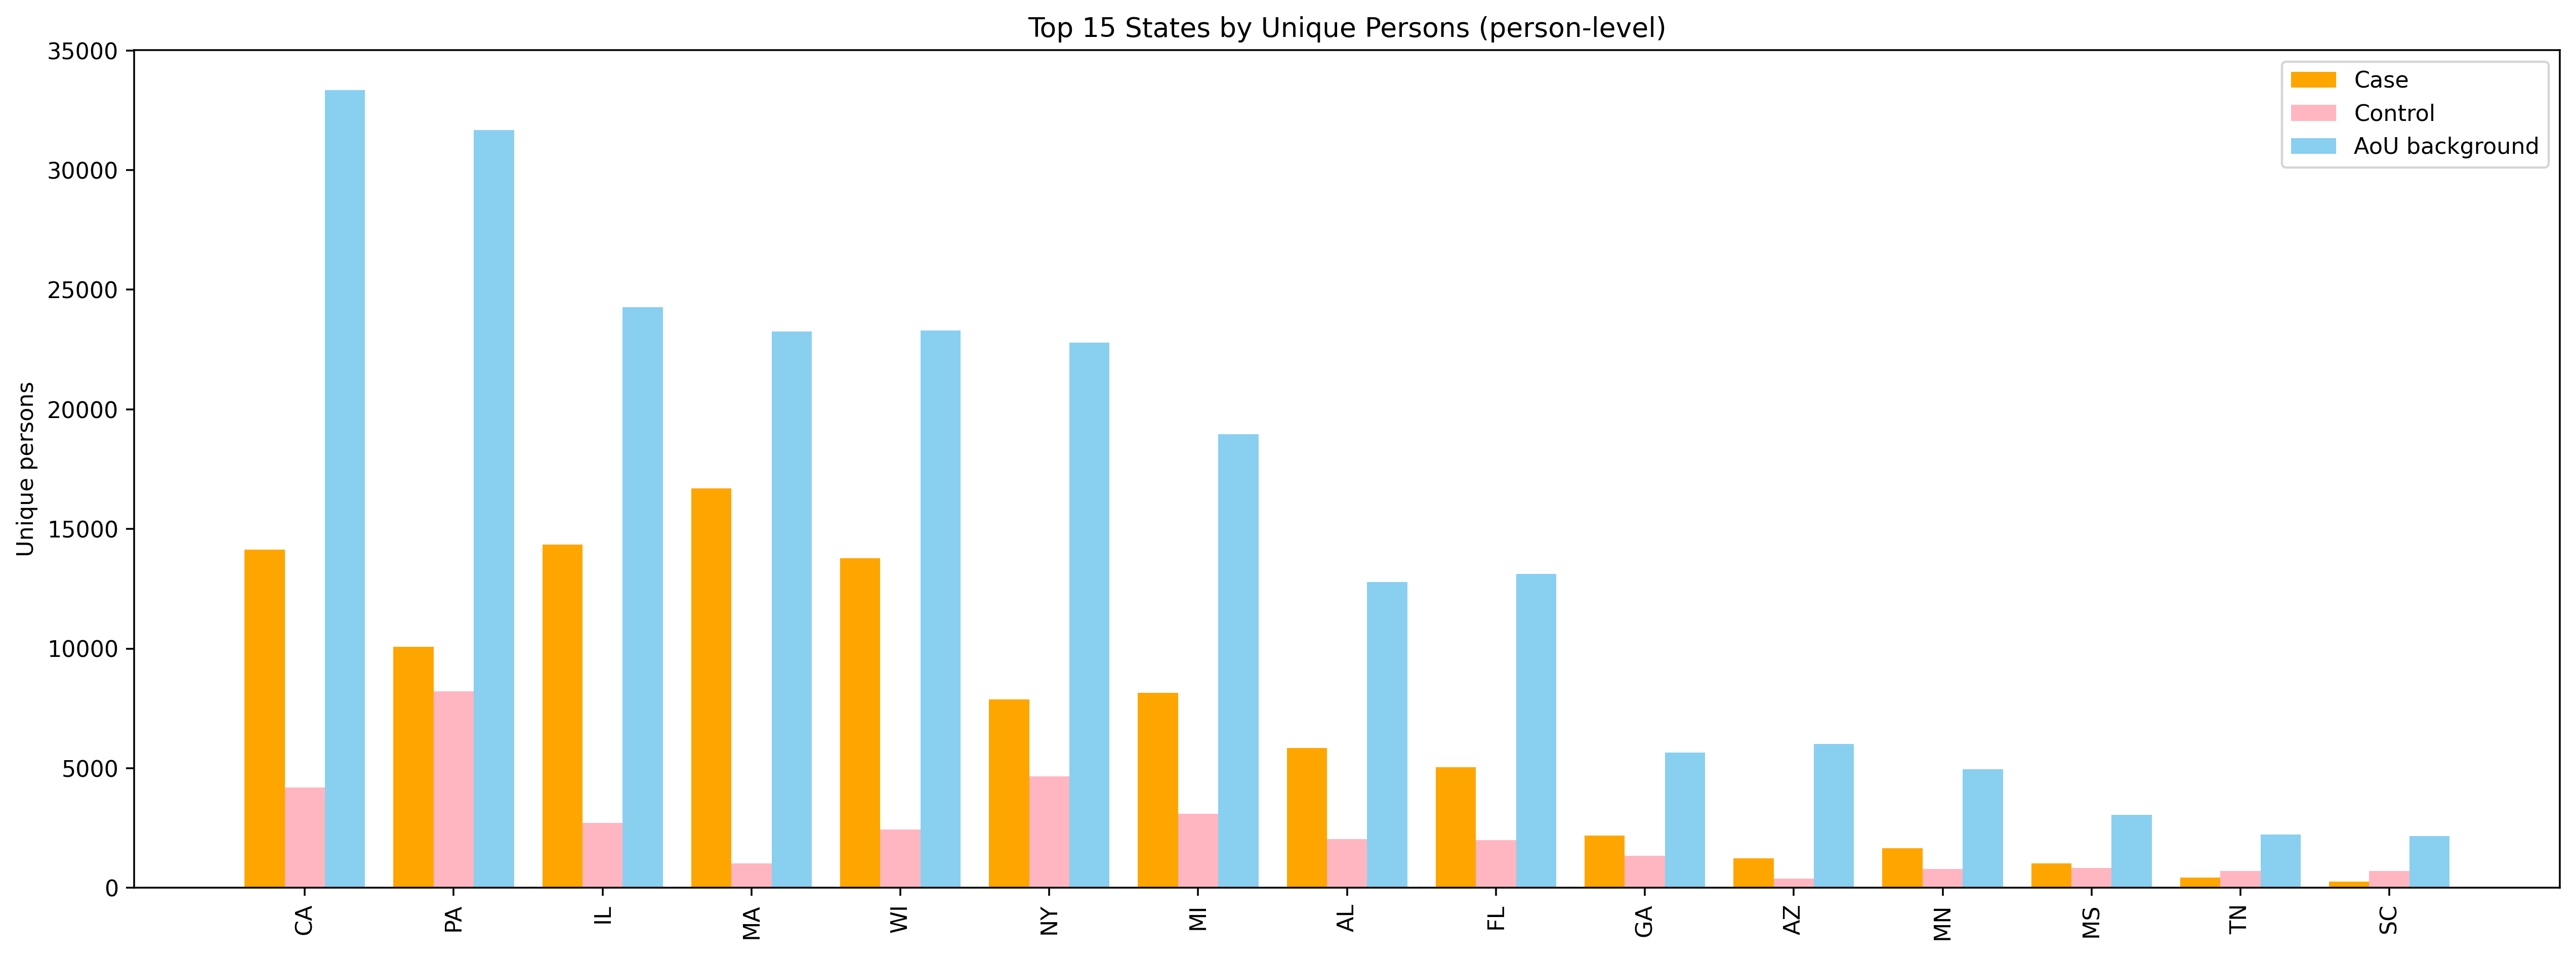

In [24]:
# Colors you requested
COL_CASE = "orange"      # case
COL_CTRL = "#FFB6C1"     # baby pink
COL_AOU  = "#89CFF0"     # baby blue

sql_states = f"""
WITH
{PERSON_JOIN},
{OUTPATIENT_SET},

-- ATC sets
atc_opioids AS (SELECT 21604254 AS atc_id),
opioid_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN atc_opioids a
    ON ca.ancestor_concept_id = a.atc_id
),
atc_ctrl AS (SELECT 21600712 AS atc_id UNION ALL SELECT 21601853),
ctrl_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN atc_ctrl a
    ON ca.ancestor_concept_id = a.atc_id
),

-- first outpatient exposure per person for each cohort
case_first AS (
  SELECT
    de.person_id,
    ANY_VALUE(d.state_of_residence) AS state,
    MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                 DATETIME(de.drug_exposure_start_date))) AS first_dt,
    ANY_VALUE(COALESCE(DATE(d.birth_datetime), DATE(d.year_of_birth,6,15))) AS birth_dt
  FROM `{CDR}.drug_exposure` de
  JOIN opioid_rxnorm r           ON de.drug_concept_id = r.drug_concept_id
  JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od        ON v.visit_concept_id    = od.visit_concept_id
  JOIN person_demographics d     ON de.person_id          = d.person_id
  GROUP BY person_id
),
opioid_users AS (SELECT person_id FROM case_first),

control_first AS (
  SELECT
    de.person_id,
    ANY_VALUE(d.state_of_residence) AS state,
    MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                 DATETIME(de.drug_exposure_start_date))) AS first_dt,
    ANY_VALUE(COALESCE(DATE(d.birth_datetime), DATE(d.year_of_birth,6,15))) AS birth_dt
  FROM `{CDR}.drug_exposure` de
  JOIN ctrl_rxnorm r              ON de.drug_concept_id   = r.drug_concept_id
  JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od         ON v.visit_concept_id   = od.visit_concept_id
  JOIN person_demographics d      ON de.person_id         = d.person_id
  LEFT JOIN opioid_users ou       ON ou.person_id         = de.person_id
  WHERE ou.person_id IS NULL
  GROUP BY person_id
),

aou_first AS (
  SELECT
    de.person_id,
    ANY_VALUE(d.state_of_residence) AS state,
    MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                 DATETIME(de.drug_exposure_start_date))) AS first_dt,
    ANY_VALUE(COALESCE(DATE(d.birth_datetime), DATE(d.year_of_birth,6,15))) AS birth_dt
  FROM `{CDR}.drug_exposure` de
  JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od         ON v.visit_concept_id     = od.visit_concept_id
  JOIN person_demographics d      ON de.person_id           = d.person_id
  GROUP BY person_id
),

c AS (SELECT state, COUNT(*) AS n_case FROM case_first    GROUP BY state),
k AS (SELECT state, COUNT(*) AS n_ctrl FROM control_first GROUP BY state),
a AS (SELECT state, COUNT(*) AS n_aou  FROM aou_first     GROUP BY state)

SELECT s.state,
       COALESCE(c.n_case,0) AS n_case,
       COALESCE(k.n_ctrl,0) AS n_ctrl,
       COALESCE(a.n_aou,0)  AS n_aou,
       COALESCE(c.n_case,0)+COALESCE(k.n_ctrl,0)+COALESCE(a.n_aou,0) AS n_total
FROM (
  SELECT DISTINCT state FROM aou_first
  UNION DISTINCT SELECT state FROM case_first
  UNION DISTINCT SELECT state FROM control_first
) s
LEFT JOIN c USING(state) LEFT JOIN k USING(state) LEFT JOIN a USING(state)
WHERE state IS NOT NULL
ORDER BY n_total DESC
LIMIT 15
"""

states_df = bq.query(sql_states).result().to_dataframe()

# Plot
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(states_df))
w = 0.27
plt.figure(figsize=(16,6))
plt.bar(x - w, states_df["n_case"],  width=w, label="Case",            color=COL_CASE)
plt.bar(x,      states_df["n_ctrl"],  width=w, label="Control",         color=COL_CTRL)
plt.bar(x + w,  states_df["n_aou"],   width=w, label="AoU background",  color=COL_AOU)
plt.xticks(x, states_df["state"], rotation=90)
plt.ylabel("Unique persons")
plt.title("Top 15 States by Unique Persons (person-level)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Monthly new users (first outpatient exposure per person)

/tmp/ipykernel_1859/2572667831.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


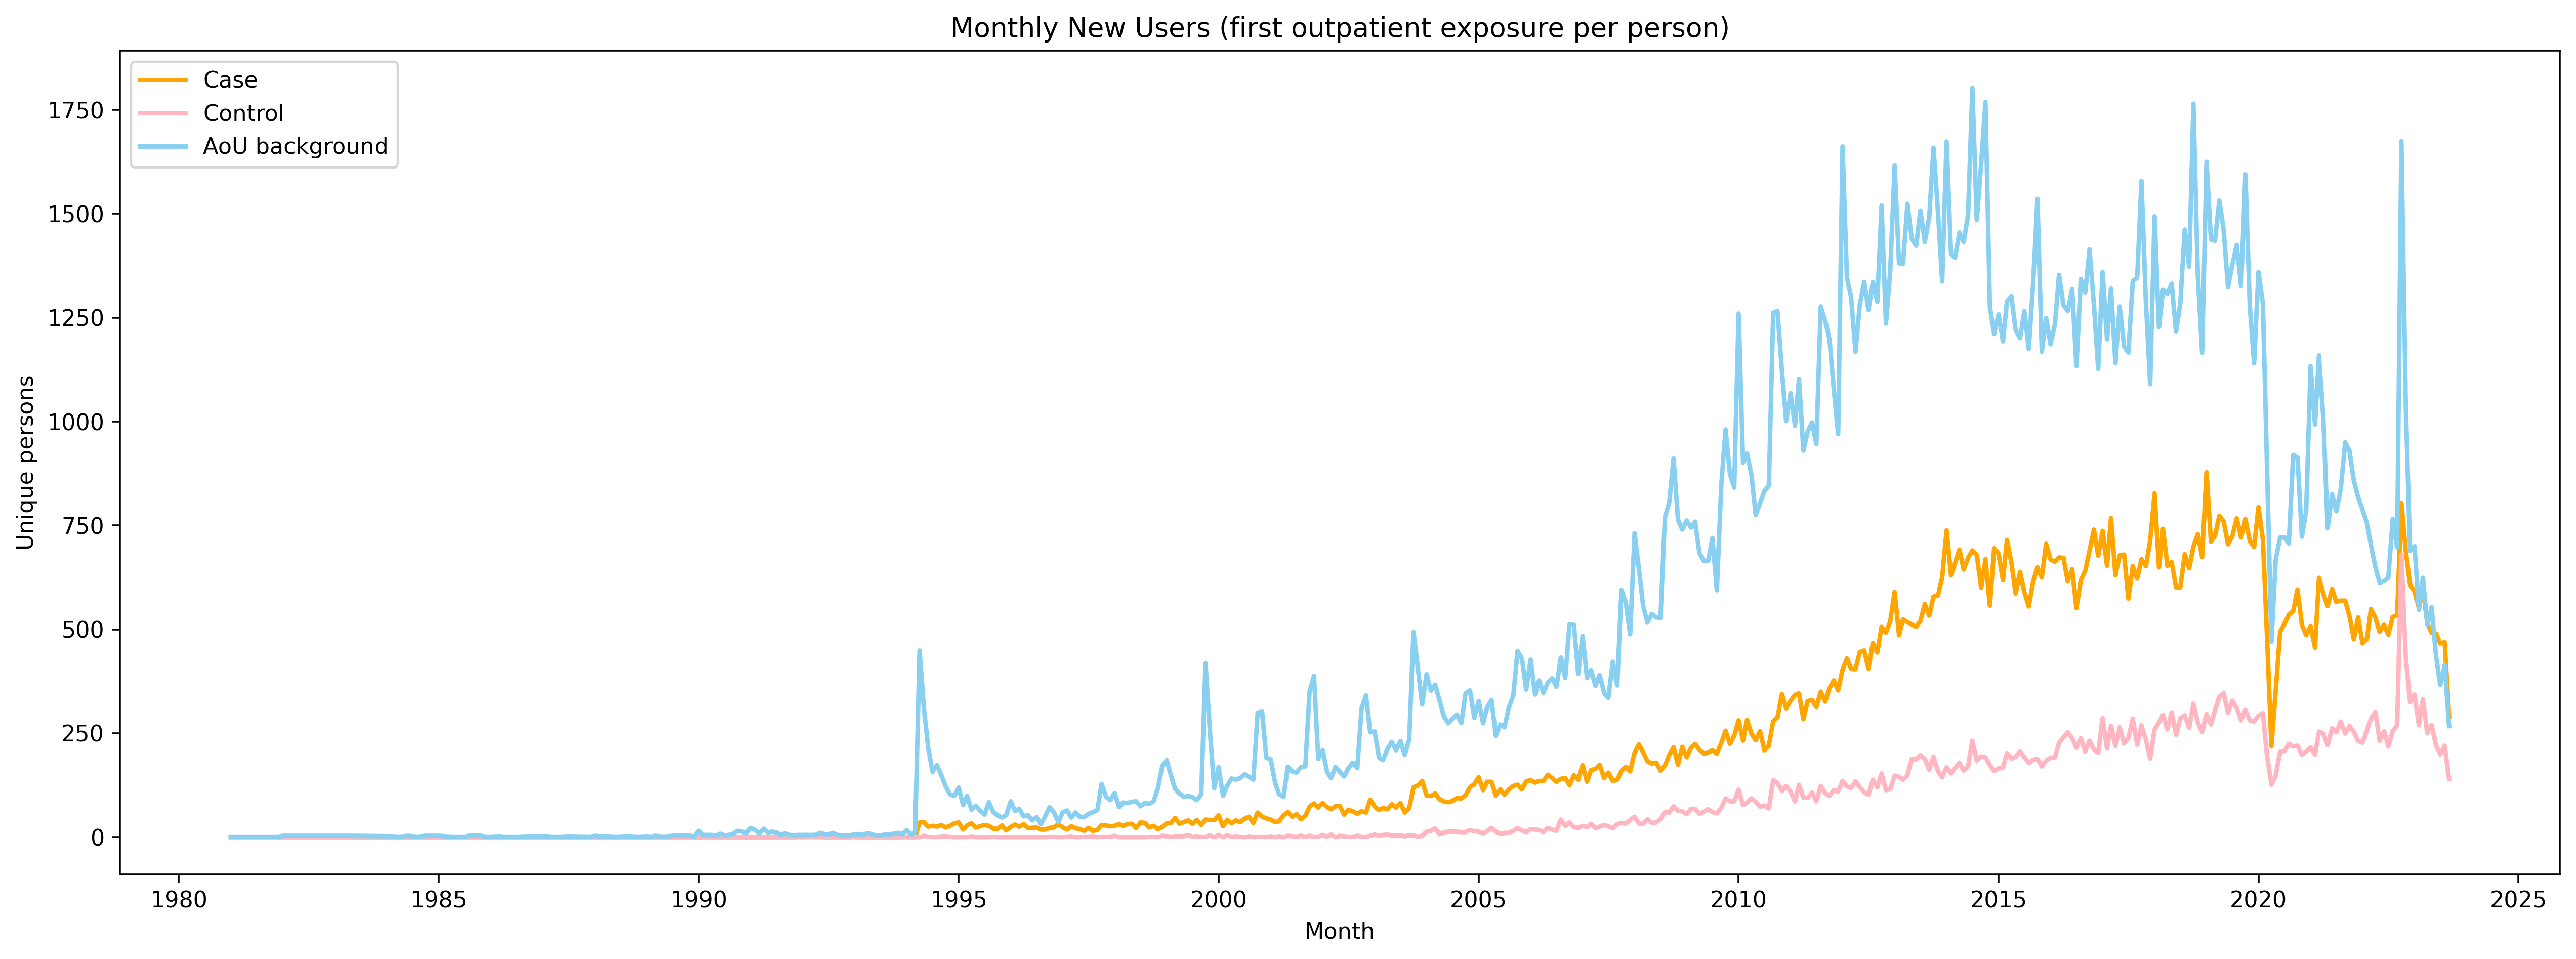

In [25]:
sql_monthly = f"""
WITH
{PERSON_JOIN},
{OUTPATIENT_SET},
atc_opioids AS (SELECT 21604254 AS atc_id),
opioid_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN atc_opioids a
    ON ca.ancestor_concept_id = a.atc_id
),
atc_ctrl AS (SELECT 21600712 AS atc_id UNION ALL SELECT 21601853),
ctrl_rxnorm AS (
  SELECT DISTINCT ca.descendant_concept_id AS drug_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN atc_ctrl a
    ON ca.ancestor_concept_id = a.atc_id
),

case_first AS (
  SELECT de.person_id,
         MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                      DATETIME(de.drug_exposure_start_date))) AS first_dt
  FROM `{CDR}.drug_exposure` de
  JOIN opioid_rxnorm r              ON de.drug_concept_id   = r.drug_concept_id
  JOIN `{CDR}.visit_occurrence` v   ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od           ON v.visit_concept_id   = od.visit_concept_id
  GROUP BY person_id
),
opioid_users AS (SELECT person_id FROM case_first),

control_first AS (
  SELECT de.person_id,
         MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                      DATETIME(de.drug_exposure_start_date))) AS first_dt
  FROM `{CDR}.drug_exposure` de
  JOIN ctrl_rxnorm r               ON de.drug_concept_id    = r.drug_concept_id
  JOIN `{CDR}.visit_occurrence` v  ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od          ON v.visit_concept_id    = od.visit_concept_id
  LEFT JOIN opioid_users ou        ON ou.person_id          = de.person_id
  WHERE ou.person_id IS NULL
  GROUP BY person_id
),
aou_first AS (
  SELECT de.person_id,
         MIN(COALESCE(DATETIME(de.drug_exposure_start_datetime),
                      DATETIME(de.drug_exposure_start_date))) AS first_dt
  FROM `{CDR}.drug_exposure` de
  JOIN `{CDR}.visit_occurrence` v ON de.visit_occurrence_id = v.visit_occurrence_id
  JOIN outpatient_desc od         ON v.visit_concept_id     = od.visit_concept_id
  GROUP BY person_id
),

case_m AS (
  SELECT DATE_TRUNC(DATE(first_dt), MONTH) AS month, COUNT(*) AS n
  FROM case_first GROUP BY month
),
ctrl_m AS (
  SELECT DATE_TRUNC(DATE(first_dt), MONTH) AS month, COUNT(*) AS n
  FROM control_first GROUP BY month
),
aou_m AS (
  SELECT DATE_TRUNC(DATE(first_dt), MONTH) AS month, COUNT(*) AS n
  FROM aou_first GROUP BY month
)
SELECT 'Case' AS cohort,   month, n FROM case_m
UNION ALL
SELECT 'Control',          month, n FROM ctrl_m
UNION ALL
SELECT 'AoU background',   month, n FROM aou_m
ORDER BY month
"""
monthly = bq.query(sql_monthly).result().to_dataframe()

# Pivot and plot
pivot = monthly.pivot(index="month", columns="cohort", values="n").fillna(0)

plt.figure(figsize=(16,6))
plt.plot(pivot.index, pivot["Case"],           label="Case",           color=COL_CASE, linewidth=2)
plt.plot(pivot.index, pivot["Control"],        label="Control",        color=COL_CTRL, linewidth=2)
plt.plot(pivot.index, pivot["AoU background"], label="AoU background", color=COL_AOU,  linewidth=2)
plt.title("Monthly New Users (first outpatient exposure per person)")
plt.xlabel("Month")
plt.ylabel("Unique persons")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Age at first outpatient exposure (person-level)

In [46]:
import pandas as pd
import numpy as np

def _coalesce_start(df):
    s = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    if "drug_exposure_start_date" in df.columns:
        s = s.fillna(pd.to_datetime(df["drug_exposure_start_date"], errors="coerce", utc=True))
    return s

def _birth_dt(df):
    b = pd.to_datetime(df.get("birth_datetime"), errors="coerce", utc=True)
    if "year_of_birth" in df.columns:
        approx = pd.to_datetime(df["year_of_birth"].astype("Int64").astype("string") + "-06-15",
                                errors="coerce", utc=True)
        b = b.fillna(approx)
    return b

def _first_age_counts(df, cohort_label):
    if df is None or df.empty:
        return pd.DataFrame(columns=["age","n","cohort"])
    x = df.copy()
    x["start_dt"] = _coalesce_start(x)
    x["birth_dt"] = _birth_dt(x)

    # first outpatient exposure per person
    x = x.dropna(subset=["person_id","start_dt","birth_dt"]).copy()
    first_idx = x.groupby("person_id")["start_dt"].idxmin()
    first = x.loc[first_idx].copy()

    # age in years at index (floor)
    first["age"] = np.floor((first["start_dt"] - first["birth_dt"]).dt.days / 365.25)
    first = first.dropna(subset=["age"]).copy()
    first["age"] = first["age"].clip(lower=0, upper=100).astype(int)

    # counts by exact age
    out = first.groupby("age").size().reset_index(name="n")
    out["cohort"] = cohort_label
    return out

frames = []
if "case_df" in globals():        frames.append(_first_age_counts(case_df, "Case"))
if "control_df" in globals():     frames.append(_first_age_counts(control_df, "Control"))
if "AoU_drug_df" in globals():    frames.append(_first_age_counts(AoU_drug_df, "AoU background"))

age_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["age","n","cohort"])
age_df.head()

,age,n,cohort
0,1,6,Case
1,2,8,Case
2,3,12,Case
3,4,15,Case
4,5,16,Case


/tmp/ipykernel_1859/4054682132.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


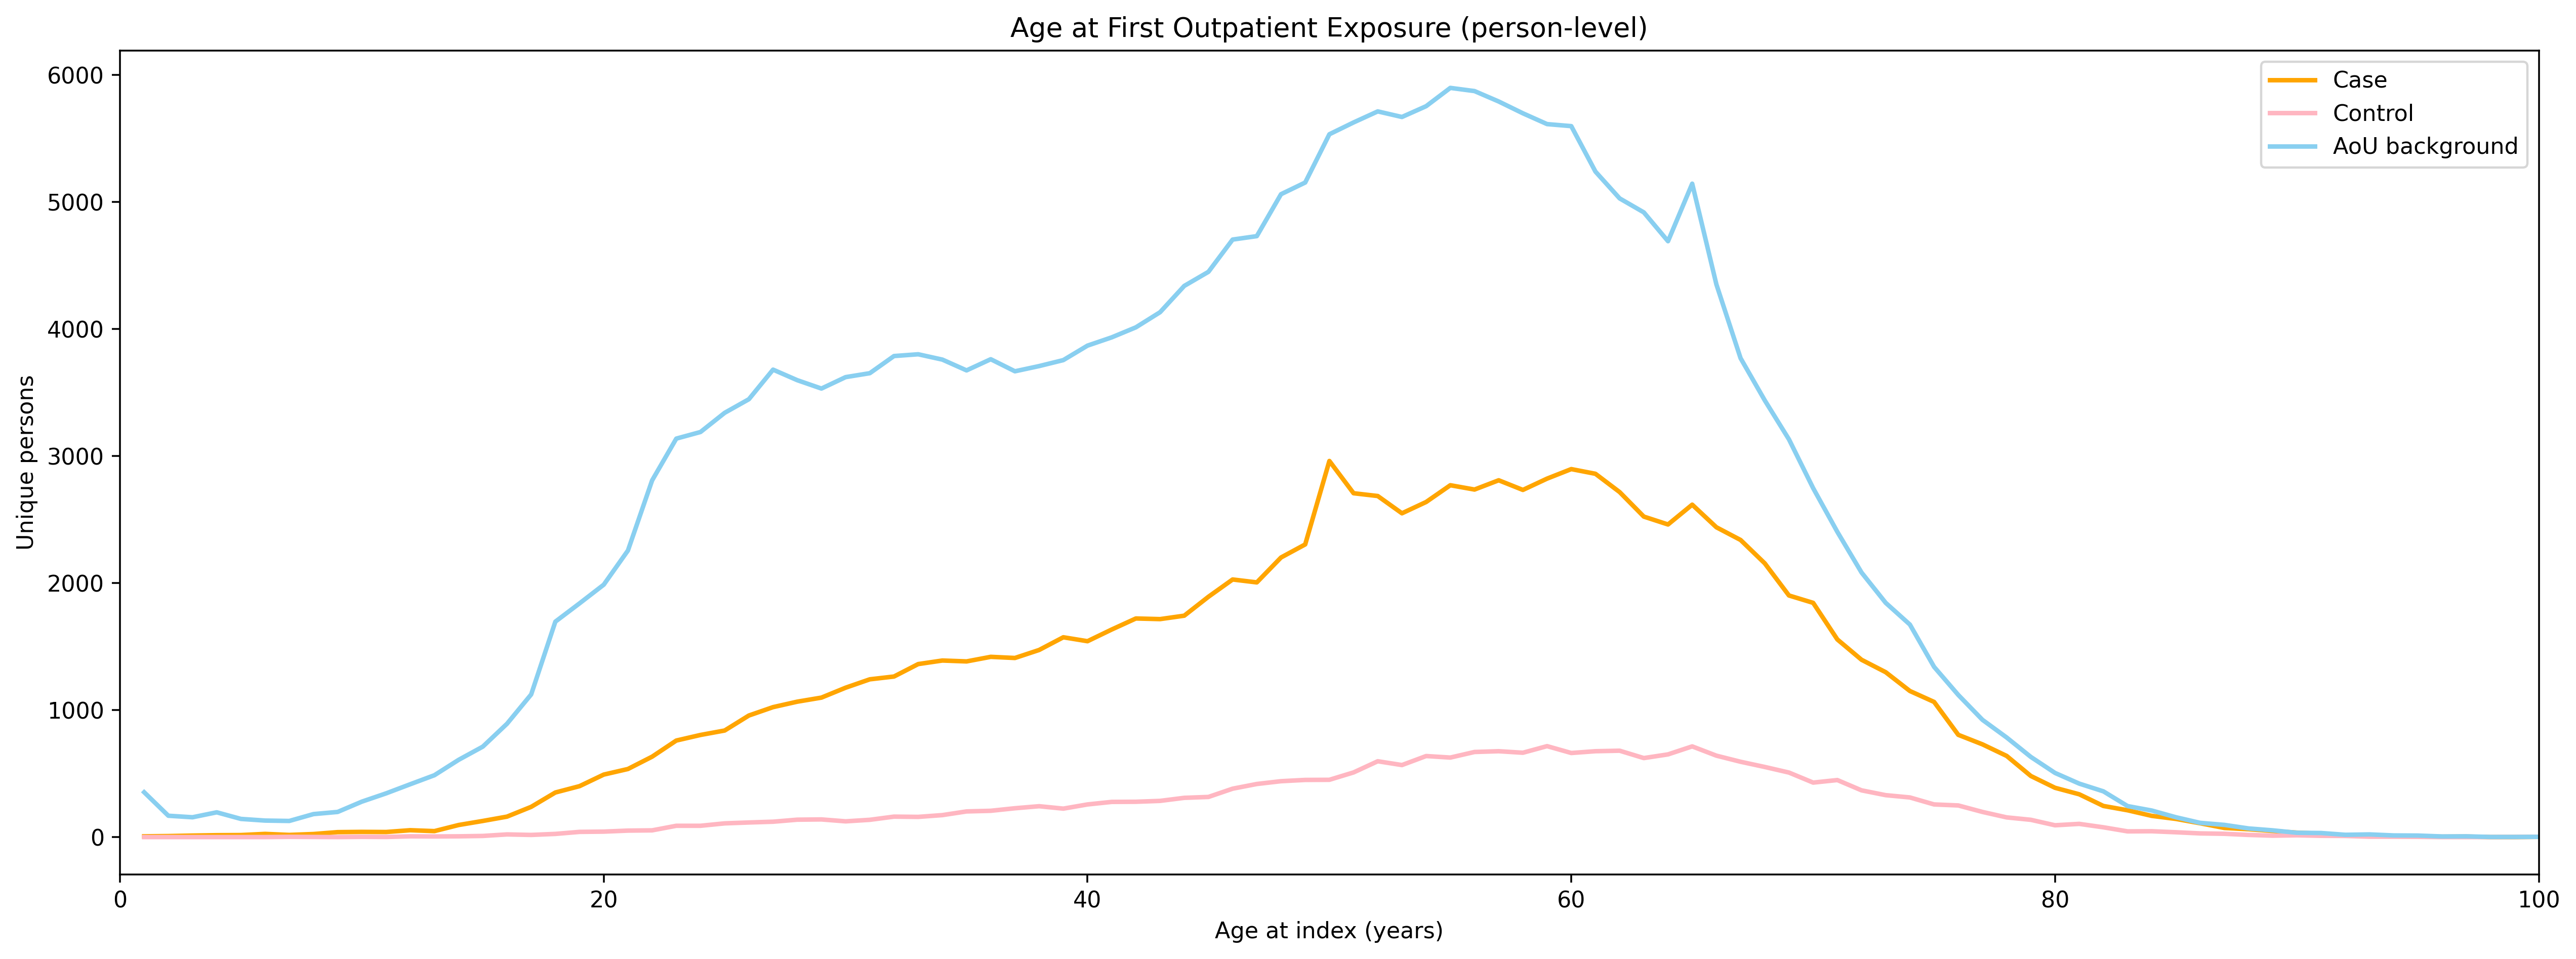

In [47]:
import matplotlib.pyplot as plt

# Clean & coalesce duplicates safely
age_df = age_df.dropna(subset=["age"]).copy()
age_df["age"] = pd.to_numeric(age_df["age"], errors="coerce").clip(lower=0, upper=100).astype(int)
age_df["n"]   = pd.to_numeric(age_df["n"], errors="coerce").fillna(0).astype(int)

# If multiple partial tables got concatenated, sum duplicates
age_df = age_df.groupby(["age","cohort"], as_index=False)["n"].sum()

# Pivot for plotting
age_piv = age_df.pivot_table(index="age", columns="cohort", values="n", aggfunc="sum", fill_value=0)

plt.figure(figsize=(16,6))
if "Case" in age_piv:           plt.plot(age_piv.index, age_piv["Case"],           label="Case",           color="orange",  linewidth=2)
if "Control" in age_piv:        plt.plot(age_piv.index, age_piv["Control"],        label="Control",        color="#FFB6C1", linewidth=2)  # baby pink
if "AoU background" in age_piv: plt.plot(age_piv.index, age_piv["AoU background"], label="AoU background", color="#89CFF0", linewidth=2)  # baby blue
plt.title("Age at First Outpatient Exposure (person-level)")
plt.xlabel("Age at index (years)")
plt.ylabel("Unique persons")
plt.xlim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## Event level

In [ ]:
# At event_level: what's the missing rate of "event_start_date", "event_end_date", "supply", ...

In [ ]:
# Step 1: confirm cohort is event-level already

In [22]:
# Case events (outpatient opioids)
total_events = len(case_df)
unique_people = case_df["person_id"].nunique()
print(f"Events (rows): {total_events:,}  |  People: {unique_people:,}")

Events (rows): 1,351,059  |  People: 107,576


In [ ]:
Step 2: Build episodes (≤30-day gap bridges events)

In [23]:
import pandas as pd
import numpy as np

GAP_DAYS = 30
LONG_TERM_DAYS = 180

def _start_dt(df):
    s = pd.to_datetime(df["drug_exposure_start_datetime"], errors="coerce", utc=True)
    s = s.fillna(pd.to_datetime(df["drug_exposure_start_date"], errors="coerce", utc=True))
    return s

def _end_dt(df):
    # end = explicit end_datetime/date; else impute from start + days_supply (if available)
    end = pd.to_datetime(df["drug_exposure_end_datetime"], errors="coerce", utc=True)
    end = end.fillna(pd.to_datetime(df["drug_exposure_end_date"], errors="coerce", utc=True))
    start = _start_dt(df)
    # If still missing, try days_supply
    if "days_supply" in df.columns:
        need = end.isna()
        end.loc[need] = (start + pd.to_timedelta(pd.to_numeric(df.loc[need, "days_supply"], errors="coerce").fillna(0), unit="D"))
    # Final fallback: same day
    end = end.fillna(start)
    return end

def make_episode_table(events: pd.DataFrame, group_across_any_opioid: bool = True) -> pd.DataFrame:
    e = events.copy()
    e["start_dt"] = _start_dt(e)
    e["end_dt"]   = _end_dt(e)
    e = e.dropna(subset=["person_id", "start_dt", "end_dt"]).sort_values(["person_id","start_dt","end_dt"])

    # Choose episode scope
    key = ["person_id"] if group_across_any_opioid else ["person_id","drug_concept_id"]

    # Gap to previous event within the scope
    e["prev_end"] = e.groupby(key)["end_dt"].shift(1)
    e["gap_days"] = (e["start_dt"] - e["prev_end"]).dt.days

    # New episode if first in group or gap > 30
    e["new_episode"] = e["gap_days"].isna() | (e["gap_days"] > GAP_DAYS)

    # Episode id within the scope
    e["episode_seq"] = e.groupby(key)["new_episode"].cumsum()

    # Aggregate to episode level
    aggs = {
        "start_dt": ["min","max"],
        "end_dt":   ["min","max"],
        "drug_exposure_id": "count"
    }
    epi = (e
           .groupby(key + ["episode_seq"], as_index=False)
           .agg(**{
               "episode_start": ("start_dt","min"),
               "episode_end":   ("end_dt","max"),
               "n_events":      ("drug_exposure_id","count")
           }))

    epi["span_days"] = (epi["episode_end"] - epi["episode_start"]).dt.days
    epi["is_long_term"] = epi["span_days"] >= LONG_TERM_DAYS

    # Keep a convenient episode key
    epi["episode_id"] = (epi["person_id"].astype(str) + "|" + epi["episode_seq"].astype(str))
    return e, epi

In [24]:
case_events, case_episodes = make_episode_table(case_df, group_across_any_opioid=True)

print(f"People: {case_df['person_id'].nunique():,}")
print(f"Events: {len(case_df):,}")
print(f"Episodes: {len(case_episodes):,}")
print(f"Events via episodes (sum n_events): {int(case_episodes['n_events'].sum()):,}")

People: 107,576
Events: 1,351,059
Episodes: 359,413
Events via episodes (sum n_events): 1,351,059


In [ ]:
Step 3: Build the distributions you want + interpret “count”

In [25]:
def describe_plus(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return pd.Series({
        "count": int(x.count()),
        "mean":  x.mean(),
        "median": x.median(),
        "std":   x.std(),
        "min":   x.min(),
        "25%":   x.quantile(.25),
        "75%":   x.quantile(.75),
        "90%":   x.quantile(.90),
        "95%":   x.quantile(.95),
        "99%":   x.quantile(.99),
        "max":   x.max(),
    }).round(2)

# 1) Event-level: number of exposure events PER PERSON
events_per_person = case_events.groupby("person_id").size()
print("Event-level: total number of exposure events per person")
print(describe_plus(events_per_person))
# -> count = number of PEOPLE summarized

# 2a) Episode-level: number of episodes PER PERSON
episodes_per_person = case_episodes.groupby("person_id").size()
print("\nEpisode-level: number of episodes per person")
print(describe_plus(episodes_per_person))
# -> count = number of PEOPLE summarized

# 2b) Episode-level: number of events PER EPISODE
events_per_episode = case_episodes["n_events"]
print("\nEpisode-level: number of events per episode")
print(describe_plus(events_per_episode))
# -> count = number of EPISODES summarized

Event-level: total number of exposure events per person
count     107576.00
mean          12.56
median         4.00
std           39.12
min            1.00
25%            2.00
75%           10.00
90%           26.00
95%           46.00
99%          147.00
max         2663.00
dtype: float64

Episode-level: number of episodes per person
count     107576.00
mean           3.34
median         2.00
std            4.61
min            1.00
25%            1.00
75%            4.00
90%            7.00
95%           11.00
99%           24.00
max          108.00
dtype: float64

Episode-level: number of events per episode
count     359413.00
mean           3.76
median         2.00
std           13.98
min            1.00
25%            1.00
75%            3.00
90%            7.00
95%           11.00
99%           32.00
max         2645.00
dtype: float64


## apendix plot

In [ ]:
# Step 4: “Which drug has the most long-term users?” (top 20)

In [53]:
# Using episodes across any opioid but attributing the episode’s DRUG to the most frequent drug within the episode
# (other choices: the first drug in the episode, or run per-drug episodes as above and keep the exact drug)
tmp = (case_events[["person_id","drug_concept_id","drug_concept_name","episode_seq"]]
       .dropna(subset=["episode_seq"]))

# Most common drug in each episode
mode_drug = (tmp
             .groupby(["person_id","episode_seq","drug_concept_id","drug_concept_name"]).size()
             .reset_index(name="n")
             .sort_values(["person_id","episode_seq","n"], ascending=[True,True,False])
             .drop_duplicates(["person_id","episode_seq"]))

epi_plus = case_episodes.merge(mode_drug, on=["person_id","episode_seq"], how="left")

long = epi_plus[epi_plus["is_long_term"]]

top20 = (long.groupby(["drug_concept_id","drug_concept_name"])
              .agg(n_long_users=("person_id","nunique"),
                   n_long_episodes=("episode_id","nunique"))
              .sort_values("n_long_users", ascending=False)
              .head(20)
              .reset_index())

top20

,drug_concept_id,drug_concept_name,n_long_users,n_long_episodes
0,19134047,tramadol hydrochloride 50 MG Oral Tablet,6095,8339
1,40232756,oxycodone hydrochloride 5 MG Oral Tablet,3417,3893
2,40221700,codeine phosphate 2 MG/ML / guaifenesin 20 MG/...,1922,2081
3,1124957,oxycodone,1778,2123
4,40221904,acetaminophen 300 MG / codeine phosphate 30 MG...,1423,1776
5,1103314,tramadol,1395,1731
6,19134049,tramadol hydrochloride 50 MG Oral Tablet [Ultram],1366,1625
7,40231925,acetaminophen 325 MG / oxycodone hydrochloride...,1280,1512
8,1201620,codeine,1209,1470
9,40169988,morphine sulfate 30 MG Extended Release Oral T...,989,1336


/tmp/ipykernel_1859/2716930691.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


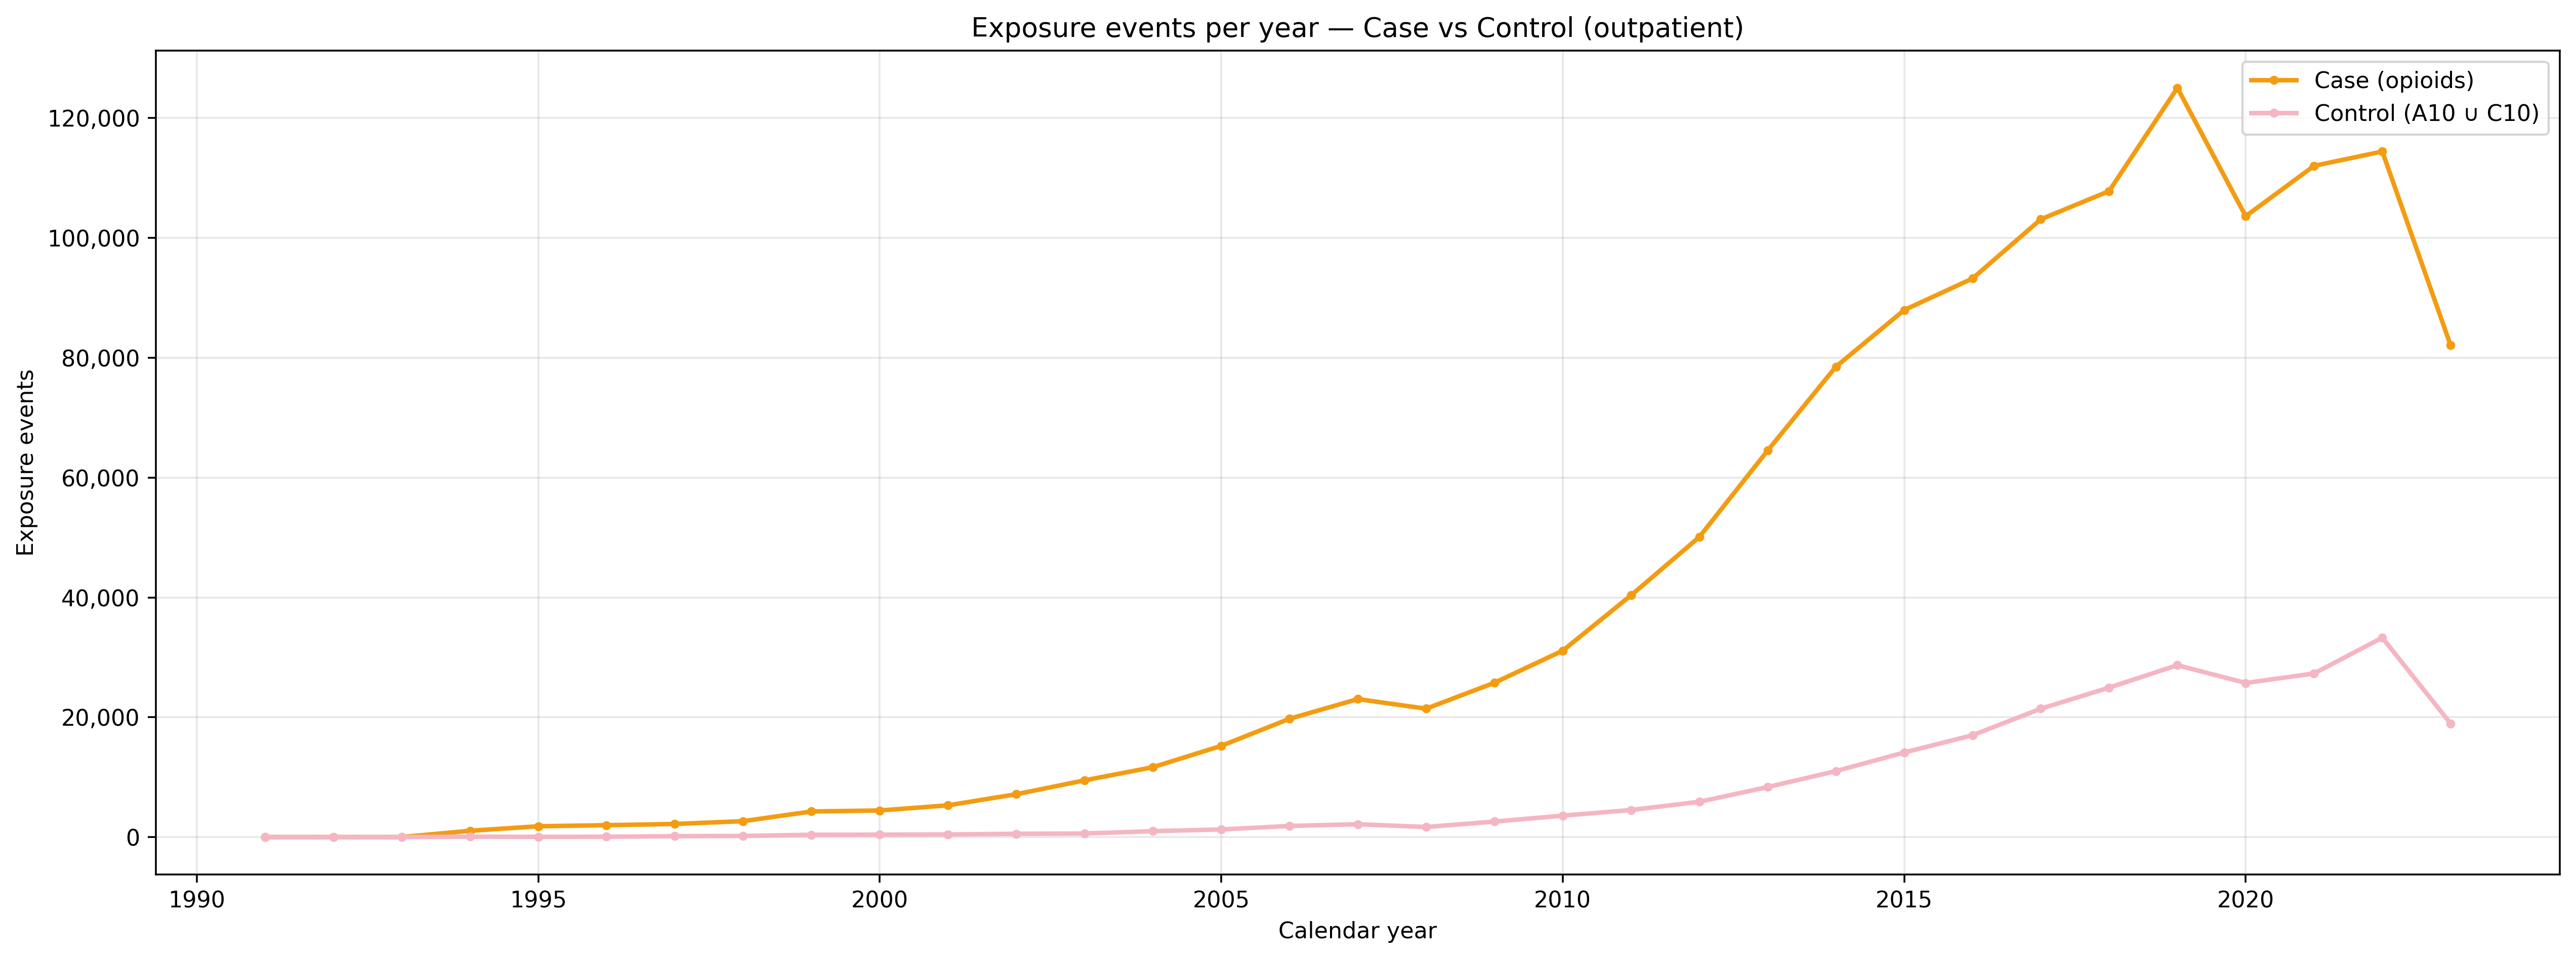

/tmp/ipykernel_1859/2716930691.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


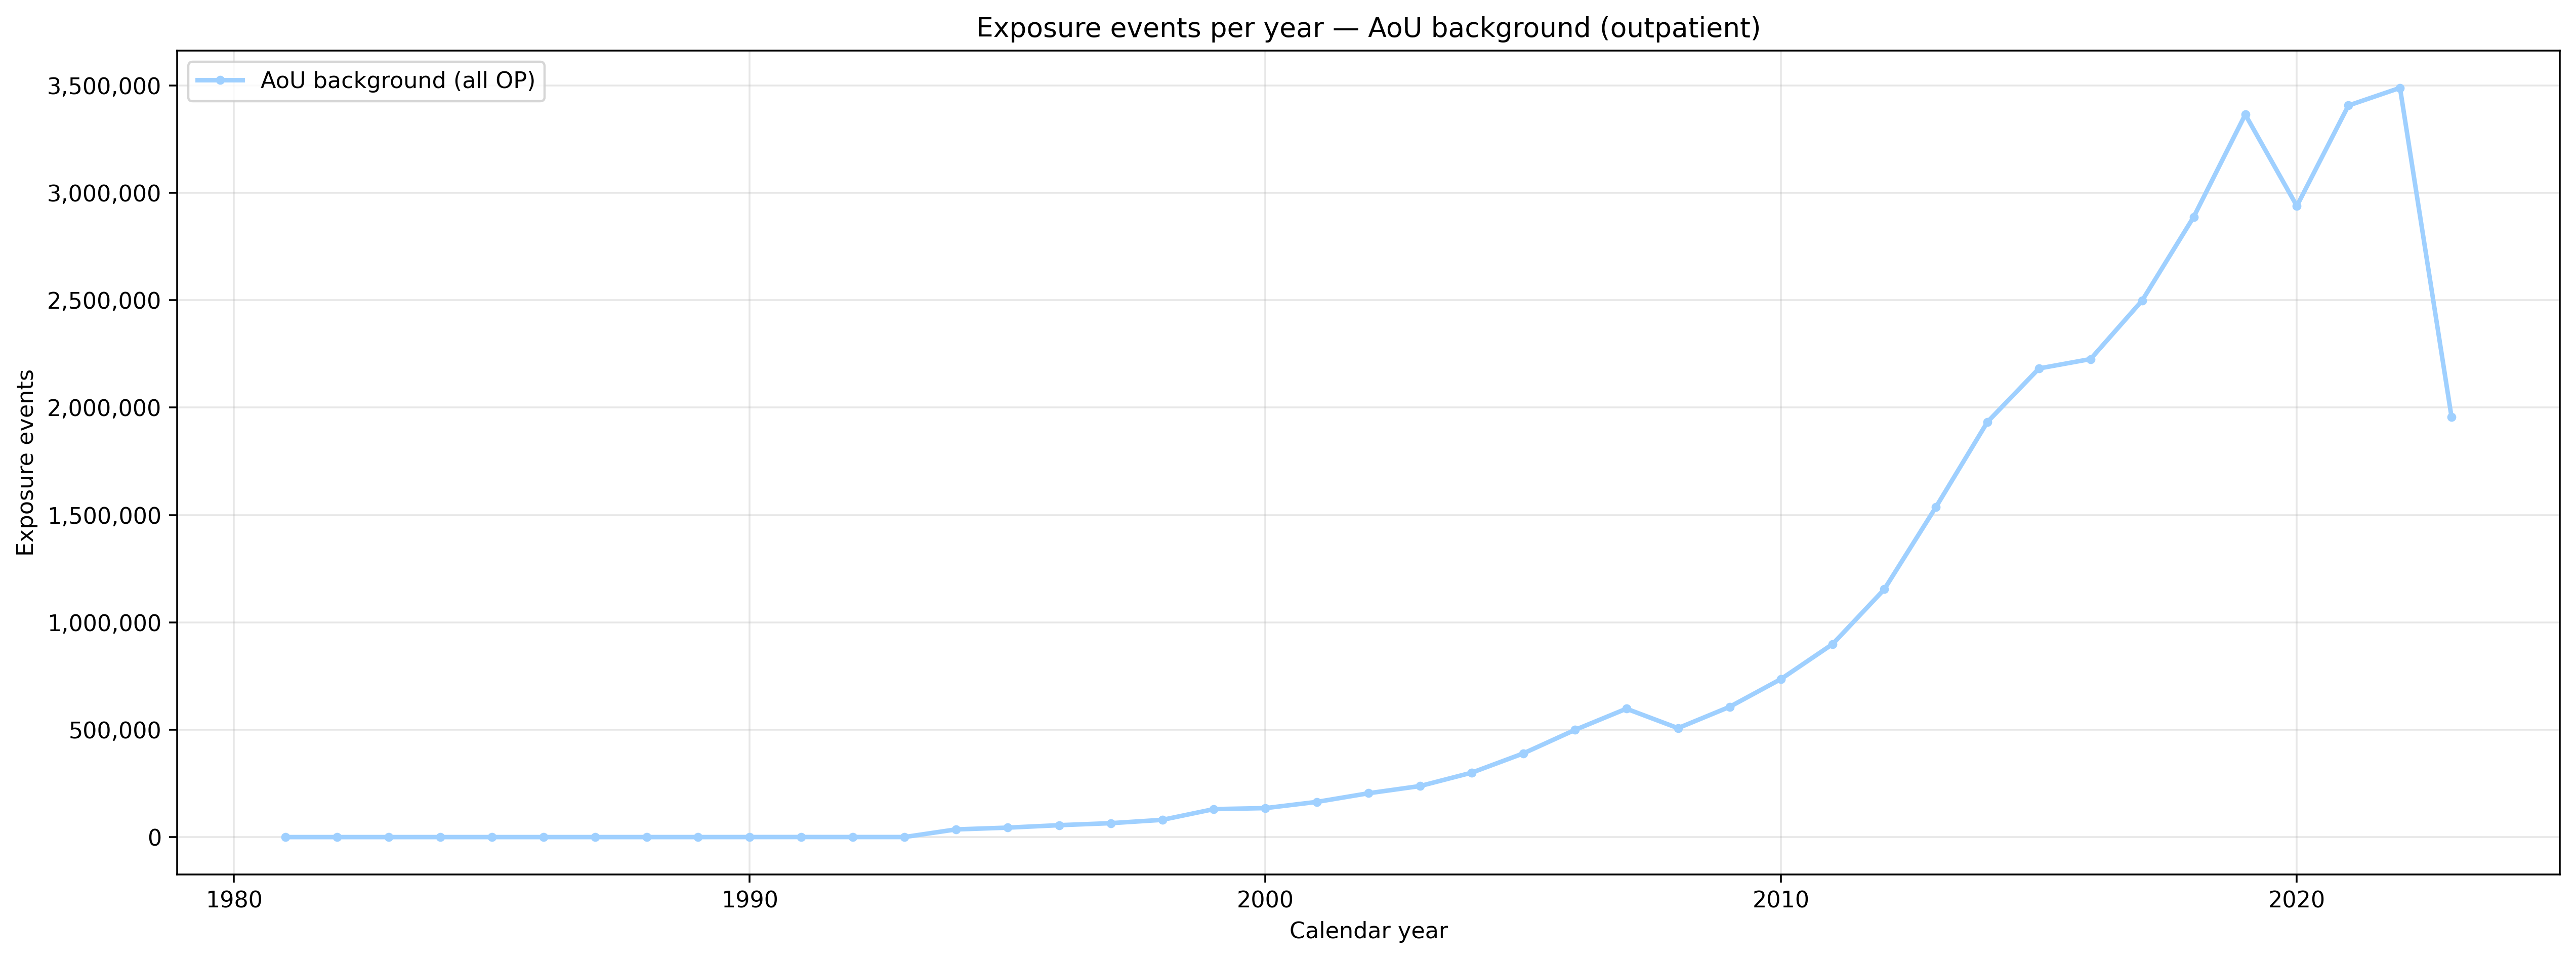

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- colors ---
COL_CASE = "#f39c12"   # orange
COL_CTRL = "#f4b6c2"   # baby pink
COL_AOU  = "#9fd0ff"   # baby blue

# --- helpers ---
def _start_coalesce(df):
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    d  = pd.to_datetime(df.get("drug_exposure_start_date"),    errors="coerce", utc=True)
    return dt.fillna(d).dt.tz_localize(None)

def yearly_counts(df, year_min=1980, year_max=2025):
    yrs = _start_coalesce(df).dt.year.dropna().astype(int)
    yrs = yrs[(yrs >= year_min) & (yrs <= year_max)]
    return yrs.value_counts().sort_index()

comma_fmt = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# --- build yearly series ---
case_years = yearly_counts(case_df)
ctrl_years = yearly_counts(control_df)
aou_years  = yearly_counts(AoU_drug_df)

# Common x for case/control
years_cc = sorted(set(case_years.index) | set(ctrl_years.index))
case_y = case_years.reindex(years_cc, fill_value=0).astype(int)
ctrl_y = ctrl_years.reindex(years_cc, fill_value=0).astype(int)

# -------- Plot 1: Case vs Control --------
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(years_cc, case_y.values, label="Case (opioids)",      color=COL_CASE, linewidth=2, marker="o", markersize=3)
ax.plot(years_cc, ctrl_y.values, label="Control (A10 ∪ C10)", color=COL_CTRL, linewidth=2, marker="o", markersize=3)
ax.set_title("Exposure events per year — Case vs Control (outpatient)")
ax.set_xlabel("Calendar year")
ax.set_ylabel("Exposure events")
ax.grid(alpha=0.3)
ax.legend()
ax.yaxis.set_major_formatter(comma_fmt)   # no ticklabel_format here
plt.tight_layout()
plt.show()

# -------- Plot 2: AoU background only --------
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(aou_years.index, aou_years.values, label="AoU background (all OP)", color=COL_AOU, linewidth=2, marker="o", markersize=3)
ax.set_title("Exposure events per year — AoU background (outpatient)")
ax.set_xlabel("Calendar year")
ax.set_ylabel("Exposure events")
ax.grid(alpha=0.3)
ax.legend()
ax.yaxis.set_major_formatter(comma_fmt)
plt.tight_layout()
plt.show()

In [ ]:
# Add rate comparison

/tmp/ipykernel_1859/3495749133.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


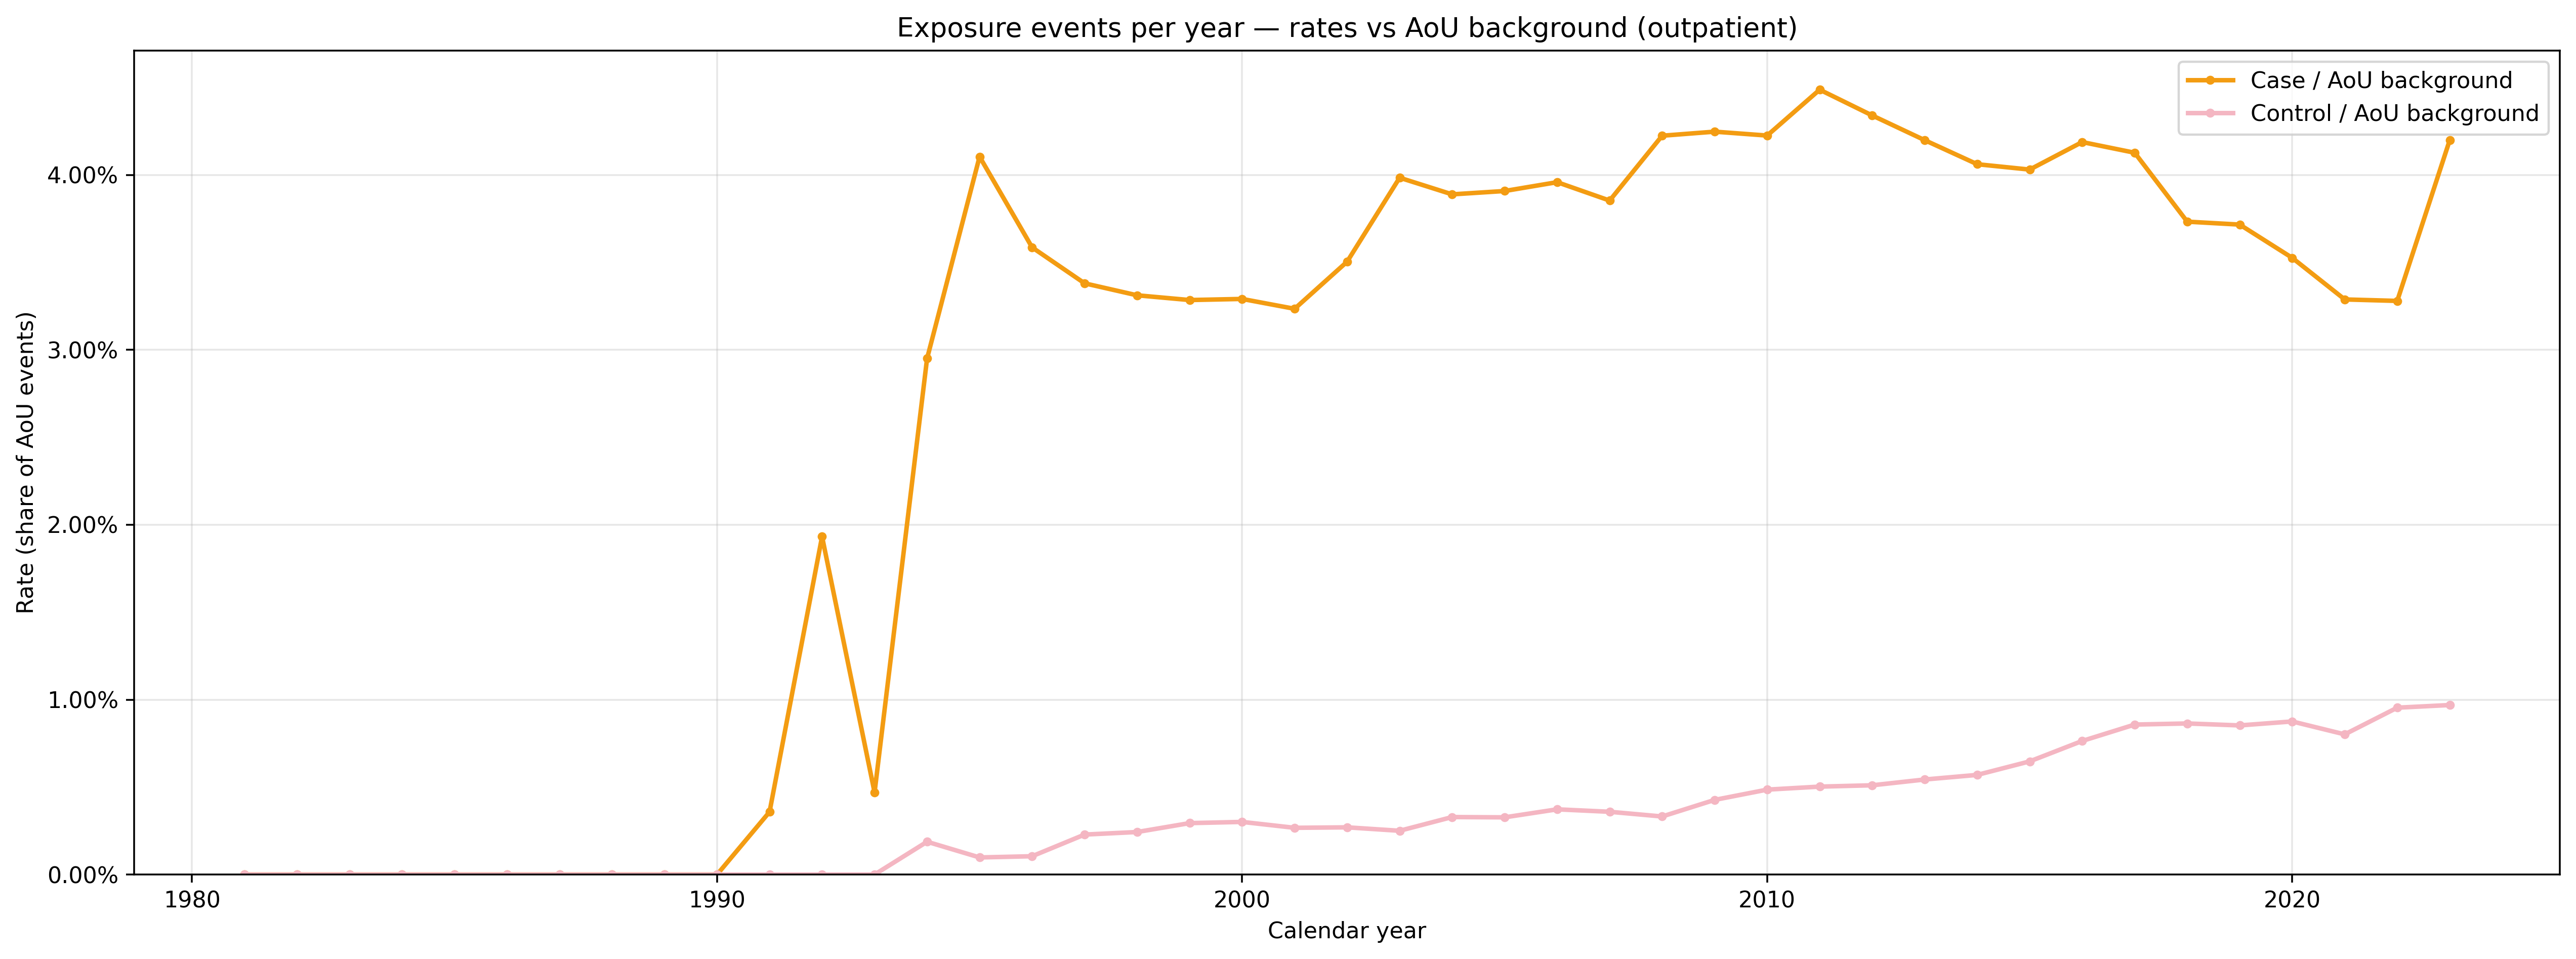

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# colors
COL_CASE = "#f39c12"   # orange
COL_CTRL = "#f4b6c2"   # baby pink

# --- helpers (same logic as earlier) ---
def _start_coalesce(df):
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    d  = pd.to_datetime(df.get("drug_exposure_start_date"),    errors="coerce", utc=True)
    return dt.fillna(d).dt.tz_localize(None)

def yearly_counts(df, year_min=1980, year_max=2025):
    yrs = _start_coalesce(df).dt.year.dropna().astype(int)
    yrs = yrs[(yrs >= year_min) & (yrs <= year_max)]
    return yrs.value_counts().sort_index()

# --- yearly totals ---
case_y = yearly_counts(case_df)
ctrl_y = yearly_counts(control_df)
aou_y  = yearly_counts(AoU_drug_df)

# restrict to years where AoU has data (>0) to avoid divide-by-zero
years = aou_y.index.sort_values()
denom = aou_y.reindex(years).astype(float)

case_rate = case_y.reindex(years, fill_value=0).astype(float).div(denom).replace([float("inf")], pd.NA)
ctrl_rate = ctrl_y.reindex(years, fill_value=0).astype(float).div(denom).replace([float("inf")], pd.NA)

# --- plot rates ---
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(years, case_rate.values, label="Case / AoU background",   color=COL_CASE, linewidth=2, marker="o", markersize=3)
ax.plot(years, ctrl_rate.values, label="Control / AoU background", color=COL_CTRL, linewidth=2, marker="o", markersize=3)

ax.set_title("Exposure events per year — rates vs AoU background (outpatient)")
ax.set_xlabel("Calendar year")
ax.set_ylabel("Rate (share of AoU events)")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))  # show 0–100%
ax.set_ylim(bottom=0)                                     # start at 0%
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # --- after case_df exists ---

# import os, pandas as pd, numpy as np
# from google.cloud import bigquery

# # Parameters
# GAP_THRESHOLD = 30                    # days to keep events in same episode
# ABUSE_IDS     = [436954, 4143110]     # abuse/misuse condition concept_ids

# # ---------- helpers ----------
# def _as_dt(primary, fallback=None):
#     dt = pd.to_datetime(primary, errors="coerce", utc=True)
#     if fallback is not None:
#         dt = dt.fillna(pd.to_datetime(fallback, errors="coerce", utc=True))
#     return dt

# def build_episodes_from_events(ev: pd.DataFrame, gap_days: int = GAP_THRESHOLD) -> pd.DataFrame:
#     """Return episode table with columns: person_id, episode_id, ep_start, ep_end, n_events, span_days."""
#     x = ev.copy()

#     # Start/end per event; impute end from days_supply if missing
#     x["start_dt"] = _as_dt(x.get("drug_exposure_start_datetime"), x.get("drug_exposure_start_date"))
#     x["end_dt"]   = _as_dt(x.get("drug_exposure_end_datetime"),   x.get("drug_exposure_end_date"))
#     if "days_supply" in x.columns:
#         miss = x["end_dt"].isna() & x["start_dt"].notna()
#         x.loc[miss, "end_dt"] = x.loc[miss, "start_dt"] + pd.to_timedelta(x.loc[miss, "days_supply"].fillna(0), unit="D")
#     bad = x["end_dt"].notna() & x["start_dt"].notna() & (x["end_dt"] < x["start_dt"])
#     x.loc[bad, "end_dt"] = x.loc[bad, "start_dt"]

#     x = x.sort_values(["person_id","start_dt"])
#     x["prev_end_dt"] = x.groupby("person_id")["end_dt"].shift(1)
#     x["gap_days"]    = (x["start_dt"] - x["prev_end_dt"]).dt.days

#     new_ep = x["gap_days"].isna() | (x["gap_days"] >= gap_days)
#     x["episode_id"] = new_ep.groupby(x["person_id"]).cumsum()

#     ep = (x.groupby(["person_id","episode_id"])
#             .agg(ep_start=("start_dt","min"),
#                  ep_end  =("end_dt","max"),
#                  n_events=("drug_exposure_id","count"))
#             .reset_index())
#     ep["span_days"] = (ep["ep_end"] - ep["ep_start"]).dt.days
#     return ep

# def chunked(seq, n=50000):
#     for i in range(0, len(seq), n):
#         yield seq[i:i+n]

# def compute_2x2_for_threshold(episodes_df: pd.DataFrame,
#                               abuse_flag: pd.Series,
#                               long_term_days: int) -> pd.DataFrame:
#     # per-person: any long episode?
#     long_by_person = (episodes_df["span_days"] >= long_term_days).groupby(
#         episodes_df["person_id"]
#     ).any().rename("has_long_episode")

#     # align with cohort people
#     people = pd.DataFrame(index=pd.Index(case_df["person_id"].unique(), name="person_id"))
#     people = people.join(long_by_person, how="left").fillna({"has_long_episode": False})
#     people = people.join(abuse_flag,   how="left").fillna({"has_abuse": False})

#     a = int(((people["has_long_episode"]) & (people["has_abuse"])).sum())
#     b = int(((people["has_long_episode"]) & (~people["has_abuse"])).sum())
#     c = int((~people["has_long_episode"] &  people["has_abuse"]).sum())
#     d = int((~people["has_long_episode"] & ~people["has_abuse"]).sum())

#     tbl = pd.DataFrame([[a, b],[c, d]],
#                        index=[f"Episode ≥{long_term_days}d: Yes", f"Episode ≥{long_term_days}d: No"],
#                        columns=["Abuse diagnosis: Yes","Abuse diagnosis: No"])
#     return tbl

# # ---------- build episodes once ----------
# episodes_case = build_episodes_from_events(case_df, GAP_THRESHOLD)

# # ---------- abuse/misuse flags once ----------
# CDR = os.environ.get("WORKSPACE_CDR")
# bq  = bigquery.Client()
# person_ids = pd.Series(case_df["person_id"].unique(), dtype="int64").tolist()

# def fetch_abuse_flags(ids_chunk):
#     sql = f"""
#     SELECT DISTINCT person_id, TRUE AS has_abuse
#     FROM `{CDR}.condition_occurrence`
#     WHERE condition_concept_id IN UNNEST(@abuse_ids)
#       AND person_id IN UNNEST(@ids)
#     """
#     job = bq.query(
#         sql,
#         job_config=bigquery.QueryJobConfig(
#             query_parameters=[
#                 bigquery.ArrayQueryParameter("abuse_ids","INT64", ABUSE_IDS),
#                 bigquery.ArrayQueryParameter("ids","INT64", ids_chunk),
#             ]
#         ),
#     )
#     return job.result().to_dataframe()

# abuse_chunks = [fetch_abuse_flags(ch) for ch in chunked(person_ids, 50000)] if person_ids else []
# abuse_df = pd.concat(abuse_chunks, ignore_index=True) if abuse_chunks else pd.DataFrame(columns=["person_id","has_abuse"])
# abuse_flag = abuse_df.set_index("person_id")["has_abuse"]

# # ---------- 2×2 for both thresholds ----------
# table_180 = compute_2x2_for_threshold(episodes_case, abuse_flag, long_term_days=180)
# table_365 = compute_2x2_for_threshold(episodes_case, abuse_flag, long_term_days=365)

# print("2×2 using LONG_TERM_DAYS = 180\n")
# print(table_180)
# print("\n2×2 using LONG_TERM_DAYS = 365\n")
# print(table_365)

## Aug 22 Meeting

In [ ]:
# Define the drug abuse & dependence condition diagnosis
# From Mark,
#ICD-9-CM
#Dependence: 304.0x (opioid), 304.1x (sedative/hypnotic/anxiolytic)
#Abuse: 305.5x (opioid), 305.4x (sedative/hypnotic/anxiolytic)
#(We purposely do not include 304.2–304.9 or 305.2–305.9 because those are other substances.)

#ICD-10-CM
#F11% (opioid) and F13% (sedative/hypnotic/anxiolytic) — includes abuse, dependence, use-unspecified, remission, and induced disorders.


# define ICD sets, map to standard, flag persons, and QA the codes captured

In [31]:
# --- 1) Earliest qualifying condition date per person (ICD9 304.0/304.1/305.5/305.4; ICD10 F11/F13) ---
cond_sql = f"""
WITH icd9_src AS (
  SELECT concept_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ICD9CM' AND invalid_reason IS NULL
    AND (
      concept_code LIKE '304.0%%' OR  -- opioid dependence
      concept_code LIKE '304.1%%' OR  -- sed/hyp/anxiolytic dependence
      concept_code LIKE '305.5%%' OR  -- opioid abuse
      concept_code LIKE '305.4%%'     -- sed/hyp/anxiolytic abuse
    )
),
icd10_src AS (
  SELECT concept_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ICD10CM' AND invalid_reason IS NULL
    AND (concept_code LIKE 'F11%%' OR concept_code LIKE 'F13%%')
),
icd_src AS (
  SELECT concept_id FROM icd9_src
  UNION DISTINCT
  SELECT concept_id FROM icd10_src
),
maps_to_std AS (
  SELECT DISTINCT cr.concept_id_2 AS std_concept_id
  FROM `{CDR}.concept_relationship` cr
  JOIN `{CDR}.concept` c2 ON c2.concept_id = cr.concept_id_2
  WHERE cr.relationship_id = 'Maps to'
    AND cr.invalid_reason IS NULL
    AND cr.concept_id_1 IN (SELECT concept_id FROM icd_src)
    AND c2.standard_concept = 'S'
    AND c2.domain_id = 'Condition'
),
std_set AS (
  SELECT std_concept_id AS condition_concept_id FROM maps_to_std
  UNION DISTINCT
  SELECT ca.descendant_concept_id
  FROM `{CDR}.concept_ancestor` ca
  JOIN maps_to_std m ON ca.ancestor_concept_id = m.std_concept_id
),
cond AS (
  SELECT
    co.person_id,
    COALESCE(DATE(co.condition_start_datetime), co.condition_start_date) AS cond_date
  FROM `{CDR}.condition_occurrence` co
  WHERE co.condition_concept_id IN (SELECT condition_concept_id FROM std_set)
     OR REGEXP_CONTAINS(UPPER(co.condition_source_value), r'^F11(\\.|)[0-9A-Z]*$')
     OR REGEXP_CONTAINS(UPPER(co.condition_source_value), r'^F13(\\.|)[0-9A-Z]*$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^304\\.0[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^304\\.1[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^305\\.5[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^305\\.4[0-9]$')
)
SELECT person_id, MIN(cond_date) AS first_cond_date
FROM cond
GROUP BY person_id
"""
cond_dates = bq.query(cond_sql).result().to_dataframe()
cond_dates["first_cond_date"] = pd.to_datetime(cond_dates["first_cond_date"], errors="coerce")

# --- 2) First opioid exposure date per person from case_df ---
def _start_coalesce(df):
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    d  = pd.to_datetime(df.get("drug_exposure_start_date"),    errors="coerce", utc=True)
    return dt.fillna(d).dt.tz_localize(None)

case_starts = (case_df
               .assign(first_exposure=_start_coalesce(case_df))
               .groupby("person_id", as_index=False)["first_exposure"]
               .min())

# --- 3) Has diagnosis after first exposure? (>=; change to '>' if you want strictly after) ---
timed_flag = (case_starts
              .merge(cond_dates, on="person_id", how="left")
              .assign(has_abuse_dep_icd_after_first_rx=lambda x:
                      (x["first_cond_date"] >= x["first_exposure"]))
              [["person_id","has_abuse_dep_icd_after_first_rx"]])

# Treat missing condition dates as False
timed_flag["has_abuse_dep_icd_after_first_rx"] = timed_flag["has_abuse_dep_icd_after_first_rx"].fillna(False)

# --- 4) Attach the flag back to every exposure row in case_df ---
case_df = case_df.merge(timed_flag.set_index("person_id"),
                        left_on="person_id", right_index=True, how="left")

case_df["has_abuse_dep_icd_after_first_rx"] = case_df["has_abuse_dep_icd_after_first_rx"].fillna(False)

# (optional) ensure boolean dtype
case_df["has_abuse_dep_icd_after_first_rx"] = case_df["has_abuse_dep_icd_after_first_rx"].astype(bool)

print("Column added: has_abuse_dep_icd_after_first_rx (True if ICD diagnosis on/after first opioid exposure).")

Column added: has_abuse_dep_icd_after_first_rx (True if ICD diagnosis on/after first opioid exposure).


In [ ]:
# Update TableOne (Ever had ICD-based abuse/dependence)

In [32]:
# ===== Rebuild person-level tables, attach ICD-based abuse/dependence flag, and render Table 1 =====
import os, numpy as np, pandas as pd
from google.cloud import bigquery

# --- 0) Inputs expected in memory: case_df, control_df, AoU_drug_df ---
bq  = bigquery.Client()
CDR = os.environ["WORKSPACE_CDR"]

# --- 1) Person-level builders (median age across exposures; normalized labels) ---
def _dt_coalesce(primary, fallback=None):
    a = pd.to_datetime(primary, errors="coerce", utc=True)
    if fallback is not None:
        b = pd.to_datetime(fallback, errors="coerce", utc=True)
        a = a.fillna(b)
    return a

def _row_age_years(df):
    start = _dt_coalesce(df.get("drug_exposure_start_datetime"), df.get("drug_exposure_start_date"))
    birth = _dt_coalesce(df.get("birth_datetime"))
    if "year_of_birth" in df.columns:
        approx = pd.to_datetime(df["year_of_birth"].astype("Int64").astype("string")+"-06-15",
                                errors="coerce", utc=True)
        birth = birth.fillna(approx)
    return np.floor((start - birth).dt.days / 365.25)

def _norm_sex(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    return "Female" if s=="female" else ("Male" if s=="male" else "Others")

def _norm_race(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    if "american indian" in s or "alaska" in s: return "American Indian or Alaska Native"
    if "asian" in s: return "Asian"
    if "black" in s or "african" in s: return "Black or African American"
    if "white" in s: return "White"
    if "middle eastern" in s or "north african" in s: return "Middle Eastern or North African"
    return "Others"

def _norm_eth(x):
    s = (str(x).strip().lower() if pd.notna(x) else "")
    if "hispanic" in s or "latino" in s:
        if "not" in s or "non" in s: return "Not Hispanic or Latino"
        return "Hispanic or Latino"
    if "not hispanic" in s or "non hispanic" in s: return "Not Hispanic or Latino"
    return "Others"

def _age_group(a):
    if pd.isna(a): return np.nan
    a = float(a)
    return ("Under 20" if a <20 else
            "20-40"    if a <40 else
            "40-60"    if a <60 else
            "60-80"    if a <80 else
            "Above 80")

def person_level_from_df(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    x["row_age"] = _row_age_years(x)
    per = (x.sort_values(["person_id"])
             .groupby("person_id", as_index=False)
             .agg({"sex_at_birth":"first","race":"first","ethnicity":"first","row_age":"median"}))
    per = per.rename(columns={"row_age":"median_age"})
    per["sex"]       = per["sex_at_birth"].map(_norm_sex)
    per["race_norm"] = per["race"].map(_norm_race)
    per["eth_norm"]  = per["ethnicity"].map(_norm_eth)
    per["age_group"] = per["median_age"].map(_age_group)
    return per[["person_id","sex","race_norm","eth_norm","median_age","age_group"]]

# Build (or rebuild) the person-level cohorts
case_person    = person_level_from_df(case_df)
control_person = person_level_from_df(control_df)
AoU_background_person = person_level_from_df(AoU_drug_df)

# --- 2) ICD-based abuse/dependence (opioids & sedatives only): ICD-9 304.0*/304.1*/305.5*/305.4*; ICD-10 F11*/F13* ---
icd_flag_sql = f"""
WITH icd9_src AS (
  SELECT concept_id, concept_code
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ICD9CM' AND invalid_reason IS NULL
    AND (concept_code LIKE '304.0%%' OR concept_code LIKE '304.1%%'
         OR concept_code LIKE '305.5%%' OR concept_code LIKE '305.4%%')
),
icd10_src AS (
  SELECT concept_id, concept_code
  FROM `{CDR}.concept`
  WHERE vocabulary_id = 'ICD10CM' AND invalid_reason IS NULL
    AND (concept_code LIKE 'F11%%' OR concept_code LIKE 'F13%%')
),
icd_src AS (
  SELECT * FROM icd9_src
  UNION DISTINCT SELECT * FROM icd10_src
),
maps_to_std AS (
  SELECT DISTINCT cr.concept_id_2 AS std_concept_id
  FROM `{CDR}.concept_relationship` cr
  JOIN `{CDR}.concept` c2 ON c2.concept_id = cr.concept_id_2
  WHERE cr.relationship_id = 'Maps to' AND cr.invalid_reason IS NULL
    AND cr.concept_id_1 IN (SELECT concept_id FROM icd_src)
    AND c2.standard_concept = 'S' AND c2.domain_id = 'Condition'
),
std_set AS (
  SELECT std_concept_id AS condition_concept_id FROM maps_to_std
  UNION DISTINCT
  SELECT ca.descendant_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN maps_to_std m
    ON ca.ancestor_concept_id = m.std_concept_id
),
icd_source_value_match AS (
  SELECT person_id
  FROM `{CDR}.condition_occurrence`
  WHERE REGEXP_CONTAINS(condition_source_value, r'^304\\.0[0-9]$')
     OR REGEXP_CONTAINS(condition_source_value, r'^304\\.1[0-9]$')
     OR REGEXP_CONTAINS(condition_source_value, r'^305\\.5[0-9]$')
     OR REGEXP_CONTAINS(condition_source_value, r'^305\\.4[0-9]$')
     OR REGEXP_CONTAINS(UPPER(condition_source_value), r'^F11(\\.|)[0-9A-Z]*$')
     OR REGEXP_CONTAINS(UPPER(condition_source_value), r'^F13(\\.|)[0-9A-Z]*$')
),
flag_person AS (
  SELECT DISTINCT person_id
  FROM `{CDR}.condition_occurrence` WHERE condition_concept_id IN (SELECT condition_concept_id FROM std_set)
  UNION DISTINCT
  SELECT DISTINCT person_id FROM icd_source_value_match
)
SELECT person_id, TRUE AS has_abuse_dep_icd FROM flag_person
"""
abuse_flag_df = bq.query(icd_flag_sql).result().to_dataframe()
abuse_flag = abuse_flag_df.set_index("person_id")["has_abuse_dep_icd"]

def attach_flag(person_df: pd.DataFrame, flag: pd.Series, col="drug_abuse_dep_icd") -> pd.DataFrame:
    out = person_df.merge(flag.rename(col), left_on="person_id", right_index=True, how="left")
    out[col] = out[col].fillna(False).map(lambda z: "Yes" if bool(z) else "No")
    return out

case_person    = attach_flag(case_person, abuse_flag)
control_person = attach_flag(control_person, abuse_flag)
AoU_background_person = attach_flag(AoU_background_person, abuse_flag)

# --- 3) Table 1 with the new section ---
SEX_ORDER = ["Female","Male","Others"]
RACE_ORDER = ["American Indian or Alaska Native","Asian","Black or African American","White","Middle Eastern or North African","Others"]
ETH_ORDER  = ["Hispanic or Latino","Not Hispanic or Latino","Others"]
AGE_ORDER  = ["Under 20","20-40","40-60","60-80","Above 80"]

N_case, N_ctrl, N_aou = len(case_person), len(control_person), len(AoU_background_person)

def _summarize(series, total, levels):
    vc = series.value_counts().reindex(levels, fill_value=0)
    pct = (vc / (total if total else 1) * 100).round(1)
    return pd.DataFrame({"level": levels, "n": vc.values, "pct": pct.values})

def _fmt(n, total, pct): return f"{int(n):,} ({pct:.1f}%)"

def _block(section_name, levels, s_case, s_ctrl, s_aou, d_case, d_ctrl, d_aou):
    c = _summarize(s_case, d_case, levels)
    k = _summarize(s_ctrl, d_ctrl, levels)
    a = _summarize(s_aou,  d_aou,  levels)
    rows = [{"Section": section_name, "Characteristic": "", "Case": "", "Control": "", "AoU background": ""}]
    for i, lvl in enumerate(levels):
        rows.append({
            "Section": "",
            "Characteristic": f"• {lvl}",
            "Case": _fmt(c.iloc[i]["n"], d_case, c.iloc[i]["pct"]),
            "Control": _fmt(k.iloc[i]["n"], d_ctrl, k.iloc[i]["pct"]),
            "AoU background": _fmt(a.iloc[i]["n"], d_aou, a.iloc[i]["pct"]),
        })
    return rows

# Age denominators after dropping NaNs
case_age = case_person["age_group"].dropna(); ctrl_age = control_person["age_group"].dropna(); aou_age = AoU_background_person["age_group"].dropna()
Ac, Ak, Aa = len(case_age), len(ctrl_age), len(aou_age)

rows = []
rows.append({"Section":"", "Characteristic":"Totals (n=)", "Case":f"n={N_case:,}", "Control":f"n={N_ctrl:,}", "AoU background":f"n={N_aou:,}"})
rows += _block("Sex at birth", SEX_ORDER, case_person["sex"], control_person["sex"], AoU_background_person["sex"], N_case, N_ctrl, N_aou)
rows += _block("Race", RACE_ORDER, case_person["race_norm"], control_person["race_norm"], AoU_background_person["race_norm"], N_case, N_ctrl, N_aou)
rows += _block("Ethnicity", ETH_ORDER, case_person["eth_norm"], control_person["eth_norm"], AoU_background_person["eth_norm"], N_case, N_ctrl, N_aou)
rows += _block("Age group (median across exposures)", AGE_ORDER, case_age, ctrl_age, aou_age, Ac, Ak, Aa)
rows += _block("Drug Abuse/Dependence (ICD)", ["Yes","No"],
               case_person["drug_abuse_dep_icd"], control_person["drug_abuse_dep_icd"], AoU_background_person["drug_abuse_dep_icd"],
               N_case, N_ctrl, N_aou)

table1_icd = pd.DataFrame(rows, columns=["Section","Characteristic","Case","Control","AoU background"])
display(table1_icd)

,Section,Characteristic,Case,Control,AoU background
0,,Totals (n=),"n=107,576","n=22,174","n=242,983"
1,Sex at birth,,,,
2,,• Female,"68,971 (64.1%)","12,688 (57.2%)","151,719 (62.4%)"
3,,• Male,"37,448 (34.8%)","9,276 (41.8%)","88,772 (36.5%)"
4,,• Others,"1,157 (1.1%)",210 (0.9%),"2,492 (1.0%)"
5,Race,,,,
6,,• American Indian or Alaska Native,758 (0.7%),140 (0.6%),"1,832 (0.8%)"
7,,• Asian,"2,338 (2.2%)",651 (2.9%),"7,199 (3.0%)"
8,,• Black or African American,"19,043 (17.7%)","4,640 (20.9%)","42,778 (17.6%)"
9,,• White,"66,736 (62.0%)","11,886 (53.6%)","143,229 (58.9%)"


In [ ]:
# Update TableOne (Drug Abuse/Dependence (ICD) after first drug_exposure)

In [34]:
# --- 2) ICD flags (EVER + AFTER FIRST OUTPATIENT EXPOSURE) ---

# (a) earliest qualifying condition date per person
icd_first_sql = f"""
WITH icd9_src AS (
  SELECT concept_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id='ICD9CM' AND invalid_reason IS NULL
    AND (concept_code LIKE '304.0%%' OR concept_code LIKE '304.1%%'
         OR concept_code LIKE '305.5%%' OR concept_code LIKE '305.4%%')
),
icd10_src AS (
  SELECT concept_id
  FROM `{CDR}.concept`
  WHERE vocabulary_id='ICD10CM' AND invalid_reason IS NULL
    AND (concept_code LIKE 'F11%%' OR concept_code LIKE 'F13%%')
),
icd_src AS (SELECT * FROM icd9_src UNION DISTINCT SELECT * FROM icd10_src),
maps_to_std AS (
  SELECT DISTINCT cr.concept_id_2 AS std_concept_id
  FROM `{CDR}.concept_relationship` cr
  JOIN `{CDR}.concept` c2 ON c2.concept_id = cr.concept_id_2
  WHERE cr.relationship_id='Maps to' AND cr.invalid_reason IS NULL
    AND cr.concept_id_1 IN (SELECT concept_id FROM icd_src)
    AND c2.standard_concept='S' AND c2.domain_id='Condition'
),
std_set AS (
  SELECT std_concept_id AS condition_concept_id FROM maps_to_std
  UNION DISTINCT
  SELECT ca.descendant_concept_id
  FROM `{CDR}.concept_ancestor` ca JOIN maps_to_std m
    ON ca.ancestor_concept_id = m.std_concept_id
),
all_hits AS (
  SELECT
    co.person_id,
    COALESCE(DATE(co.condition_start_datetime), co.condition_start_date) AS cond_date
  FROM `{CDR}.condition_occurrence` co
  WHERE co.condition_concept_id IN (SELECT condition_concept_id FROM std_set)
     OR REGEXP_CONTAINS(co.condition_source_value, r'^304\\.0[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^304\\.1[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^305\\.5[0-9]$')
     OR REGEXP_CONTAINS(co.condition_source_value, r'^305\\.4[0-9]$')
     OR REGEXP_CONTAINS(UPPER(co.condition_source_value), r'^F11(\\.|)[0-9A-Z]*$')
     OR REGEXP_CONTAINS(UPPER(co.condition_source_value), r'^F13(\\.|)[0-9A-Z]*$')
)
SELECT person_id, MIN(cond_date) AS first_cond_date
FROM all_hits
GROUP BY person_id
"""
cond_dates = bq.query(icd_first_sql).result().to_dataframe()
cond_dates["first_cond_date"] = pd.to_datetime(cond_dates["first_cond_date"], errors="coerce")

# (b) first outpatient exposure date per cohort
def _first_op_exposure(df: pd.DataFrame) -> pd.DataFrame:
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce", utc=True)
    d  = pd.to_datetime(df.get("drug_exposure_start_date"),    errors="coerce", utc=True)
    start = dt.fillna(d).dt.tz_localize(None)
    return (pd.DataFrame({"person_id": df["person_id"], "first_exposure": start})
              .dropna()
              .groupby("person_id", as_index=False)["first_exposure"].min())

case_first   = _first_op_exposure(case_df)
ctrl_first   = _first_op_exposure(control_df)
aou_first    = _first_op_exposure(AoU_drug_df)

# (c) attach flags to person-level tables
def _attach_icd_flags(person_df, first_df, cond_df,
                      col_ever="drug_abuse_dep_icd_ever",
                      col_after="drug_abuse_dep_icd_after_first_op"):
    out = person_df.merge(cond_df, on="person_id", how="left") \
                   .merge(first_df, on="person_id", how="left")
    # ever
    out[col_ever]  = out["first_cond_date"].notna()
    # after first outpatient exposure (>= same day counts as after; change to '>' if desired)
    out[col_after] = (out["first_cond_date"] >= out["first_exposure"])
    out[col_after] = out[col_after].fillna(False)
    # present as Yes/No strings
    out[col_ever]  = out[col_ever].map(lambda z: "Yes" if z else "No")
    out[col_after] = out[col_after].map(lambda z: "Yes" if z else "No")
    return out.drop(columns=["first_cond_date","first_exposure"])

case_person    = _attach_icd_flags(case_person,   case_first, cond_dates)
control_person = _attach_icd_flags(control_person, ctrl_first, cond_dates)
AoU_background_person = _attach_icd_flags(AoU_background_person, aou_first, cond_dates)

# --- 3) Table 1 with BOTH variants (keep one or both) ---

rows = []
rows.append({"Section":"", "Characteristic":"Totals (n=)",
             "Case":f"n={len(case_person):,}",
             "Control":f"n={len(control_person):,}",
             "AoU background":f"n={len(AoU_background_person):,}"})
rows += _block("Sex at birth", SEX_ORDER,
               case_person["sex"], control_person["sex"], AoU_background_person["sex"],
               len(case_person), len(control_person), len(AoU_background_person))
rows += _block("Race", RACE_ORDER,
               case_person["race_norm"], control_person["race_norm"], AoU_background_person["race_norm"],
               len(case_person), len(control_person), len(AoU_background_person))
rows += _block("Ethnicity", ETH_ORDER,
               case_person["eth_norm"], control_person["eth_norm"], AoU_background_person["eth_norm"],
               len(case_person), len(control_person), len(AoU_background_person))
# Age uses non-missing denominators
case_age = case_person["age_group"].dropna()
ctrl_age = control_person["age_group"].dropna()
aou_age  = AoU_background_person["age_group"].dropna()
rows += _block("Age group (median across exposures)", AGE_ORDER,
               case_age, ctrl_age, aou_age,
               len(case_age), len(ctrl_age), len(aou_age))

# NEW sections:
rows += _block("OP Drug Abuse/Dependence (EVER)", ["Yes","No"],
               case_person["drug_abuse_dep_icd_ever"],
               control_person["drug_abuse_dep_icd_ever"],
               AoU_background_person["drug_abuse_dep_icd_ever"],
               len(case_person), len(control_person), len(AoU_background_person))

rows += _block("OP Drug Abuse/Dependence (AFTER FIRST OP EXPO)", ["Yes","No"],
               case_person["drug_abuse_dep_icd_after_first_op"],
               control_person["drug_abuse_dep_icd_after_first_op"],
               AoU_background_person["drug_abuse_dep_icd_after_first_op"],
               len(case_person), len(control_person), len(AoU_background_person))

table1_icd = pd.DataFrame(rows, columns=["Section","Characteristic","Case","Control","AoU background"])
display(table1_icd)

,Section,Characteristic,Case,Control,AoU background
0,,Totals (n=),"n=107,576","n=22,174","n=242,983"
1,Sex at birth,,,,
2,,• Female,"68,971 (64.1%)","12,688 (57.2%)","151,719 (62.4%)"
3,,• Male,"37,448 (34.8%)","9,276 (41.8%)","88,772 (36.5%)"
4,,• Others,"1,157 (1.1%)",210 (0.9%),"2,492 (1.0%)"
5,Race,,,,
6,,• American Indian or Alaska Native,758 (0.7%),140 (0.6%),"1,832 (0.8%)"
7,,• Asian,"2,338 (2.2%)",651 (2.9%),"7,199 (3.0%)"
8,,• Black or African American,"19,043 (17.7%)","4,640 (20.9%)","42,778 (17.6%)"
9,,• White,"66,736 (62.0%)","11,886 (53.6%)","143,229 (58.9%)"


## Plots Explore

In [ ]:
# plots at phenotype level

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _parse_index_datetime(df):
    # prefer datetime, fall back to date
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce")
    if "drug_exposure_start_date" in df.columns:
        dt = dt.fillna(pd.to_datetime(df["drug_exposure_start_date"], errors="coerce"))
    return dt

def prepare_for_plots(df):
    df = df.copy()
    df["index_datetime"] = _parse_index_datetime(df)

    # age at index (prefer birth_datetime; fallback to year_of_birth)
    bd = pd.to_datetime(df.get("birth_datetime"), errors="coerce")
    if bd.notna().any():
        df["age_at_index"] = np.floor((df["index_datetime"] - bd).dt.days / 365.25)
    elif "year_of_birth" in df.columns:
        df["age_at_index"] = df["index_datetime"].dt.year - df["year_of_birth"]
    else:
        df["age_at_index"] = np.nan
    return df

def bar_compare(case_series, ctrl_series, title, top_n=None, rotation=45):
    s1 = case_series.fillna("Missing").astype(str).value_counts()
    s0 = ctrl_series.fillna("Missing").astype(str).value_counts()
    if top_n:
        s1 = s1.head(top_n); s0 = s0.head(top_n)
    cats = list((set(s1.index) | set(s0.index)))
    cats.sort()
    y1 = [int(s1.get(c, 0)) for c in cats]
    y0 = [int(s0.get(c, 0)) for c in cats]

    plt.figure(figsize=(9,4.5))
    x = np.arange(len(cats))
    width = 0.42
    plt.bar(x - width/2, y1, width=width, label="Case")
    plt.bar(x + width/2, y0, width=width, label="Control")
    plt.xticks(x, cats, rotation=rotation, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def line_compare(case_ts, ctrl_ts, title):
    # case_ts / ctrl_ts: pandas Series indexed by period/DatetimeIndex
    plt.figure(figsize=(9,4.5))
    case_ts.plot(label="Case")
    ctrl_ts.plot(label="Control")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def hist_compare(case_vals, ctrl_vals, bins=40, title=""):
    plt.figure(figsize=(9,4.5))
    plt.hist(case_vals.dropna(), bins=bins, density=False, histtype="step", label="Case")
    plt.hist(ctrl_vals.dropna(), bins=bins, density=False, histtype="step", label="Control")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- prep ----------
case_plot = prepare_for_plots(case_df)
ctrl_plot = prepare_for_plots(control_df)

# ---------- 1) Age distribution ----------
hist_compare(case_plot["age_at_index"], ctrl_plot["age_at_index"], bins=40, title="Event Age at Index (years)")

# ---------- 2) Sex at birth ----------
if "sex_at_birth" in case_plot.columns and "sex_at_birth" in ctrl_plot.columns:
    bar_compare(case_plot["sex_at_birth"], ctrl_plot["sex_at_birth"], "Sex at Birth")

# ---------- 3) Race ----------
if "race" in case_plot.columns and "race" in ctrl_plot.columns:
    bar_compare(case_plot["race"], ctrl_plot["race"], "Race (Top Categories)", top_n=10)

# ---------- 4) Ethnicity ----------
if "ethnicity" in case_plot.columns and "ethnicity" in ctrl_plot.columns:
    bar_compare(case_plot["ethnicity"], ctrl_plot["ethnicity"], "Ethnicity")
    
# ---------- 5) State of residence (if present) ----------
# Top 15 states by total samples (case + control) with comparisons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def _fix_state(s: pd.Series) -> pd.Series:
    if s is None:
        return pd.Series(dtype=object)
    return s.fillna("Missing").astype(str)

# pull states (fall back to "Missing" if the column isn't present)
case_state = _fix_state(case_df.get("state_of_residence"))
ctrl_state = _fix_state(control_df.get("state_of_residence"))

# counts per state
case_counts = case_state.value_counts().rename_axis("state").reset_index(name="case_n")
ctrl_counts = ctrl_state.value_counts().rename_axis("state").reset_index(name="control_n")

# merge + totals
state_counts = case_counts.merge(ctrl_counts, on="state", how="outer").fillna(0)
state_counts["case_n"] = state_counts["case_n"].astype(int)
state_counts["control_n"] = state_counts["control_n"].astype(int)
state_counts["total_n"] = state_counts["case_n"] + state_counts["control_n"]

# select top 15 by total
top15 = state_counts.sort_values("total_n", ascending=False).head(15).copy()

# within-state composition
top15["case_pct_of_state"] = np.where(top15["total_n"] > 0, 100 * top15["case_n"] / top15["total_n"], 0.0)
top15["control_pct_of_state"] = np.where(top15["total_n"] > 0, 100 * top15["control_n"] / top15["total_n"], 0.0)
top15["case_minus_control_pp"] = top15["case_pct_of_state"] - top15["control_pct_of_state"]

# nice order for plotting
cats = top15["state"].tolist()
x = np.arange(len(cats))

# --- Plot 1: counts by state (top 15) ---
plt.figure(figsize=(14, 6))
width = 0.42
plt.bar(x - width/2, top15["case_n"], width=width, label="Case")
plt.bar(x + width/2, top15["control_n"], width=width, label="Control")
plt.xticks(x, cats, rotation=90)
plt.title("Top 15 States by Total Samples: Case vs Control (counts)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- 6) Exposure trend over time (monthly first exposures per person) ----------
def first_exposure_per_person(df):
    return (df.sort_values(["person_id","index_datetime"])
              .dropna(subset=["index_datetime"])
              .groupby("person_id", as_index=False)
              .first())

case_first  = first_exposure_per_person(case_plot)
ctrl_first  = first_exposure_per_person(ctrl_plot)

case_monthly = case_first.set_index("index_datetime").resample("MS")["person_id"].count()
ctrl_monthly = ctrl_first.set_index("index_datetime").resample("MS")["person_id"].count()
line_compare(case_monthly, ctrl_monthly, "Monthly New Users (first exposure per person)")


In [ ]:
# Age at their first drug exposure as well
# Plot

# Add all AoU backgroud line

In [ ]:
# ===== Table-style cohort comparison: case_df vs control_df =====
import pandas as pd
import numpy as np
from IPython.display import display

# ---------- helpers ----------
def _parse_index_datetime(df: pd.DataFrame) -> pd.Series:
    dt = pd.to_datetime(df.get("drug_exposure_start_datetime"), errors="coerce")
    if "drug_exposure_start_date" in df.columns:
        dt = dt.fillna(pd.to_datetime(df["drug_exposure_start_date"], errors="coerce"))
    return dt

def _first_exposure_per_person(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    x["index_datetime"] = _parse_index_datetime(x)
    x = (x.dropna(subset=["index_datetime"])
           .sort_values(["person_id","index_datetime"])
           .groupby("person_id", as_index=False)
           .first())
    return x

def _age_at_index(df_ix: pd.DataFrame) -> pd.Series:
    # prefer birth_datetime; fallback to year_of_birth
    if "birth_datetime" in df_ix.columns and df_ix["birth_datetime"].notna().any():
        bd = pd.to_datetime(df_ix["birth_datetime"], errors="coerce")
        return np.floor((df_ix["index_datetime"] - bd).dt.days / 365.25)
    elif "year_of_birth" in df_ix.columns:
        return df_ix["index_datetime"].dt.year - df_ix["year_of_birth"]
    return pd.Series(np.nan, index=df_ix.index)

def _num_summary(s: pd.Series) -> dict:
    s = pd.to_numeric(s, errors="coerce")
    q1, q3 = s.quantile([0.25, 0.75])
    return {
        "n": int(s.notna().sum()),
        "mean": float(s.mean()),
        "sd": float(s.std(ddof=1)),
        "median": float(s.median()),
        "q1": float(q1),
        "q3": float(q3),
        "min": float(s.min()),
        "max": float(s.max()),
    }

def _smd_cont(x, y):
    x = pd.to_numeric(x, errors="coerce"); y = pd.to_numeric(y, errors="coerce")
    return (np.nanmean(x) - np.nanmean(y)) / np.sqrt((np.nanvar(x, ddof=1) + np.nanvar(y, ddof=1))/2)

def _smd_cat(series_case, series_ctrl):
    # Generalized (multi-category) SMD
    p1 = series_case.value_counts(normalize=True)
    p0 = series_ctrl.value_counts(normalize=True)
    cats = p1.index.union(p0.index)
    diff = (p1.reindex(cats, fill_value=0) - p0.reindex(cats, fill_value=0))
    pooled = ((p1.reindex(cats, fill_value=0) + p0.reindex(cats, fill_value=0))/2).replace(0, np.nan)
    return float(np.nansum((diff**2 / pooled))**0.5)

def _compare_categorical(series_case, series_ctrl, label, top_n=None):
    c = series_case.fillna("Missing").astype(str)
    k = series_ctrl.fillna("Missing").astype(str)
    n1, n0 = len(c), len(k)
    vc1 = c.value_counts()
    vc0 = k.value_counts()

    # Choose display categories (union of tops) to keep the table manageable
    if top_n:
        cats = list((set(vc1.head(top_n).index) | set(vc0.head(top_n).index)))
    else:
        cats = list((set(vc1.index) | set(vc0.index)))
    cats.sort()

    rows = []
    for cat in cats:
        n_case = int(vc1.get(cat, 0))
        n_ctrl = int(vc0.get(cat, 0))
        p_case = n_case / n1 if n1 else 0.0
        p_ctrl = n_ctrl / n0 if n0 else 0.0
        rows.append({
            label: cat,
            "Case n": n_case, "Case %": f"{100*p_case:.1f}",
            "Control n": n_ctrl, "Control %": f"{100*p_ctrl:.1f}",
            "Δ pp (Case–Ctrl)": f"{100*(p_case - p_ctrl):+.1f}"
        })

    tbl = pd.DataFrame(rows)
    # Add a global multi-category SMD for reference (same value on all rows)
    smd_val = _smd_cat(c, k)
    tbl["SMD (global)"] = f"{smd_val:.3f}"
    return tbl

def _format_overview_row(name, case_val, ctrl_val):
    return {"Measure": name, "Case": case_val, "Control": ctrl_val}

# ---------- compute index cohorts ----------
case_ix = _first_exposure_per_person(case_df)
ctrl_ix = _first_exposure_per_person(control_df)

case_ix["age_at_index"] = _age_at_index(case_ix)
ctrl_ix["age_at_index"] = _age_at_index(ctrl_ix)

# ---------- overview table ----------
# Sizes
case_persons, ctrl_persons = len(case_ix), len(ctrl_ix)
case_exposures, ctrl_exposures = len(case_df), len(control_df)

# Index date ranges
case_range = f"{case_ix['index_datetime'].min().date()} – {case_ix['index_datetime'].max().date()}"
ctrl_range = f"{ctrl_ix['index_datetime'].min().date()} – {ctrl_ix['index_datetime'].max().date()}"

# Age summaries
as_case = _num_summary(case_ix["age_at_index"])
as_ctrl = _num_summary(ctrl_ix["age_at_index"])

overview_rows = [
    _format_overview_row("Persons (index)", case_persons, ctrl_persons),
    _format_overview_row("Exposures (rows)", case_exposures, ctrl_exposures),
    _format_overview_row("Index date range", case_range, ctrl_range),
    _format_overview_row("Age mean (SD)", f"{as_case['mean']:.1f} ({as_case['sd']:.1f})", f"{as_ctrl['mean']:.1f} ({as_ctrl['sd']:.1f})"),
    _format_overview_row("Age median [IQR]", f"{as_case['median']:.1f} [{as_case['q1']:.1f},{as_case['q3']:.1f}]", f"{as_ctrl['median']:.1f} [{as_ctrl['q1']:.1f},{as_ctrl['q3']:.1f}]"),
    _format_overview_row("Age SMD", f"{_smd_cont(case_ix['age_at_index'], ctrl_ix['age_at_index']):.3f}", ""),
]
overview_tbl = pd.DataFrame(overview_rows)

# ---------- categorical tables (person-level) ----------
sex_tbl = _compare_categorical(case_ix.get("sex_at_birth", pd.Series(dtype=object)),
                               ctrl_ix.get("sex_at_birth", pd.Series(dtype=object)),
                               label="Sex at birth")

race_tbl = _compare_categorical(case_ix.get("race", pd.Series(dtype=object)),
                                ctrl_ix.get("race", pd.Series(dtype=object)),
                                label="Race", top_n=12)

eth_tbl = _compare_categorical(case_ix.get("ethnicity", pd.Series(dtype=object)),
                               ctrl_ix.get("ethnicity", pd.Series(dtype=object)),
                               label="Ethnicity")


# ---------- top drugs at index (person-level) ----------
def _top_drugs(ix_df, k=20):
    vc = ix_df.get("drug_concept_name", pd.Series(dtype=object)).fillna("Missing").astype(str).value_counts().head(k)
    return vc.rename_axis("Drug concept").reset_index(name="n")

case_top = _top_drugs(case_ix, 20)
ctrl_top = _top_drugs(ctrl_ix, 20)
top_drugs_tbl = (case_top.merge(ctrl_top, on="Drug concept", how="outer", suffixes=(" (Case)", " (Control)"))
                         .fillna(0).astype({"n (Case)":"int64","n (Control)":"int64"}))

# ---------- days_supply (exposure-level) ----------
def _exposure_num_tbl(df_case, df_ctrl, col):
    if col not in df_case.columns or col not in df_ctrl.columns:
        return pd.DataFrame(columns=["Measure","Case","Control"])
    cs = _num_summary(pd.to_numeric(df_case[col], errors="coerce"))
    ds = _num_summary(pd.to_numeric(df_ctrl[col], errors="coerce"))
    rows = [
        _format_overview_row("n (non-missing)", cs["n"], ds["n"]),
        _format_overview_row("mean (SD)", f"{cs['mean']:.1f} ({cs['sd']:.1f})", f"{ds['mean']:.1f} ({ds['sd']:.1f})"),
        _format_overview_row("median [IQR]", f"{cs['median']:.1f} [{cs['q1']:.1f},{cs['q3']:.1f}]", f"{ds['median']:.1f} [{ds['q1']:.1f},{ds['q3']:.1f}]"),
        _format_overview_row("min – max", f"{cs['min']:.1f} – {cs['max']:.1f}", f"{ds['min']:.1f} – {ds['max']:.1f}"),
    ]
    return pd.DataFrame(rows)

days_supply_tbl = _exposure_num_tbl(case_df, control_df, "days_supply")

# ---------- show everything ----------
print("=== OVERVIEW (person-level) ===")
display(overview_tbl)

print("\n=== SEX AT BIRTH (person-level) ===")
display(sex_tbl)

print("\n=== RACE (person-level) ===")
display(race_tbl)

print("\n=== ETHNICITY (person-level) ===")
display(eth_tbl)

print("\n=== TOP DRUGS AT INDEX (person-level) ===")
display(top_drugs_tbl)
      
print("\n=== DAYS SUPPLY (exposure-level) ===")
display(days_supply_tbl)

# --- Table: counts, percents, and percentage-point gap ---
out_cols = [
    "state", "total_n", "case_n", "control_n",
    "case_pct_of_state", "control_pct_of_state", "case_minus_control_pp"
]
tbl = top15[out_cols].copy()
tbl = tbl.rename(columns={
    "state": "State",
    "total_n": "Total n",
    "case_n": "Case n",
    "control_n": "Control n",
    "case_pct_of_state": "Case % (within state)",
    "control_pct_of_state": "Control % (within state)",
    "case_minus_control_pp": "Case–Control Δ (pp)"
})
# round percentages for display
for c in ["Case % (within state)", "Control % (within state)", "Case–Control Δ (pp)"]:
    tbl[c] = tbl[c].map(lambda v: f"{v:.1f}")

display(tbl.reset_index(drop=True))

In [ ]:
# --- Top 20 opioids in CASE (from case_df) vs counts in CONTROL (same 20) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _fix_series(s):
    return s.fillna("Missing").astype(str)

def bar_compare_fixed_categories(series_case, series_ctrl, cats, title, rotation=90):
    c = _fix_series(series_case)
    k = _fix_series(series_ctrl)

    y1 = [int((c == cat).sum()) for cat in cats]
    y0 = [int((k == cat).sum()) for cat in cats]

    x = np.arange(len(cats))
    width = 0.42
    fig = plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, y1, width=width, label="Case")
    plt.bar(x + width/2, y0, width=width, label="Control")
    plt.xticks(x, cats, rotation=rotation, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Build a table too (counts + % of cohort)
    n_case = len(c)
    n_ctrl = len(k)
    tbl = pd.DataFrame({
        "drug_concept_name": cats,
        "case_n": y1,
        "case_%": [100 * v / n_case if n_case else 0 for v in y1],
        "control_n": y0,
        "control_%": [100 * v / n_ctrl if n_ctrl else 0 for v in y0],
    })
    return tbl

# use your already prepped plotting copies if you have them; otherwise use raw dfs
case_src = case_plot if "case_plot" in globals() else case_df
ctrl_src = ctrl_plot if "ctrl_plot" in globals() else control_df

# 1) EXPSOSURE-LEVEL: pick top 20 from CASE and compare to CONTROL
top20_case_exposure = (
    _fix_series(case_src["drug_concept_name"])
    .value_counts()
    .head(20)
    .index
    .tolist()
)

top20_exposure_tbl = bar_compare_fixed_categories(
    case_src["drug_concept_name"],
    ctrl_src["drug_concept_name"],
    top20_case_exposure,
    title="Top 20 opioids in CASE (exposure-level) vs CONTROL",
    rotation=90,
)

display(top20_exposure_tbl)

In [ ]:
# Question:
# Maybe we can only compare the long-term users of different drugs (top drugs) for each group?